# History

### Ver2
* VIF 분석을 통해 피처 선택을 수행하고 테스트합니다.
* VIF 분석 결과 제거할 피처가 없어 permutation_importance 함수를 사용 후 제거할 피쳐를 선택합니다.
* Perform feature selection through VIF analysis and test it.
* After conducting the VIF analysis and finding no features to remove, I will now use the permutation_importance function to determine which features to remove.

### Ver3
* RNF와 Type컬럼을 제거한 데이터에 대해서 모델을 학습하고 튜닝합니다.
* Train and fine-tune the model using the data excluding the 'RNF' and 'Type' columns.

### Ver5
* 버전 4는 기각되고 DL 모델의 구조를 변경하고 다시 튜닝을 시도합니다.
* Version 4 is rejected, and we will proceed to alter the structure of the deep learning model and attempt tuning once again.

### Ver6
* 새로운 피처를 생성합니다.
    * 별로 상관관계가 없는 RNF를 제외한 TWF, HDF, PWF, OSF 네개의 피처를 이용하여 실패지수를 표현합니다.
    * Air temperature [K] - Process temperature [K]를 구해 diff_temperature를 계산합니다.
    * Torque(토크)를 RPM(분당 회전수)으로 나눠  Specific_Torque를 계산합니다.
* 피처 생성 후 xgboost의 feature importance를 확인합니다.

In [2]:
# !pip install git+https://github.com/tooha289/DataAnalysisLibrary.git

# 사용 모듈 Import

In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DataAnalysis import eda
from DataAnalysis import feature_engineering

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.optimizers import Adam

import optuna

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# 0. Check GPU

In [4]:
import tensorflow as tf

# GPU 디바이스 목록 가져오기
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# GPU 사용 가능한 경우
if gpu_devices:
    for device in gpu_devices:
        print("GPU 사용 가능:", device)
else:
    print("GPU 사용 불가능")

GPU 사용 가능: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Load & Check Data

In [5]:
df = pd.read_csv('../data/train.csv')
df

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [6]:
test_df = pd.read_csv('../data/test.csv')
test_df

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [8]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,136429.0,NaN,NaN,NaN,68214.0,39383.804275,0.0,34107.0,68214.0,102321.0,136428.0
Product ID,136429,9976,L53257,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,136429,3,L,95354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],136429.0,NaN,NaN,NaN,299.862776,1.862247,295.3,298.3,300.0,301.2,304.4
Process temperature [K],136429.0,NaN,NaN,NaN,309.94107,1.385173,305.8,308.7,310.0,310.9,313.8
Rotational speed [rpm],136429.0,NaN,NaN,NaN,1520.33111,138.736632,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],136429.0,NaN,NaN,NaN,40.348643,8.502229,3.8,34.6,40.4,46.1,76.6
Tool wear [min],136429.0,NaN,NaN,NaN,104.408901,63.96504,0.0,48.0,106.0,159.0,253.0
Machine failure,136429.0,NaN,NaN,NaN,0.015744,0.124486,0.0,0.0,0.0,0.0,1.0
TWF,136429.0,NaN,NaN,NaN,0.001554,0.039389,0.0,0.0,0.0,0.0,1.0


In [9]:
df.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

# 2. FeatureEngineering

## 2.0 Feature Creation

* 별로 상관관계가 없는 RNF를 제외한 TWF, HDF, PWF, OSF 네개의 피처를 이용하여 failure_index를 표현합니다.

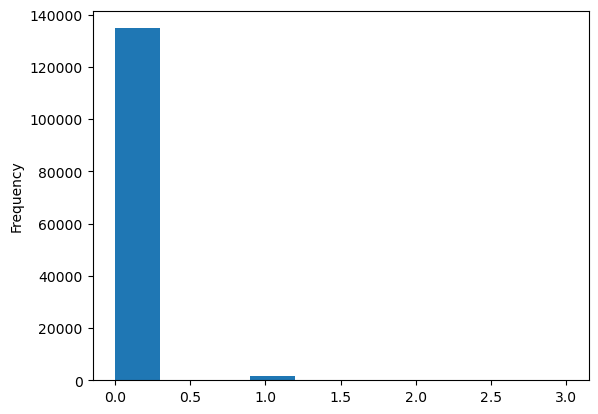

In [10]:
failure_index = df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"]
failure_index.plot(kind="hist")
df["failure_index"] = failure_index

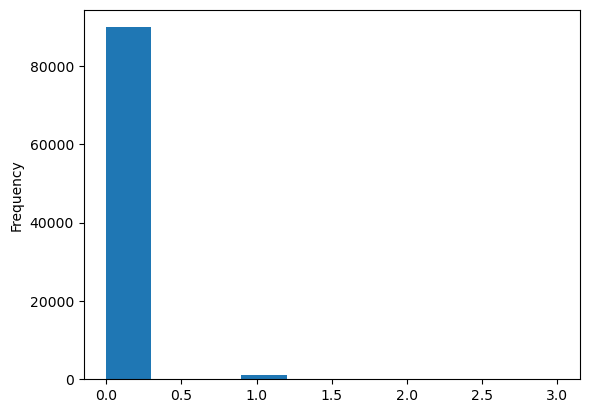

In [11]:
failure_index = test_df["TWF"] + test_df["HDF"] + test_df["PWF"] + test_df["OSF"]
failure_index.plot(kind="hist")
test_df["failure_index"] = failure_index

* Air temperature [K] - Process temperature [K]를 구해 diff_temperature를 계산합니다.

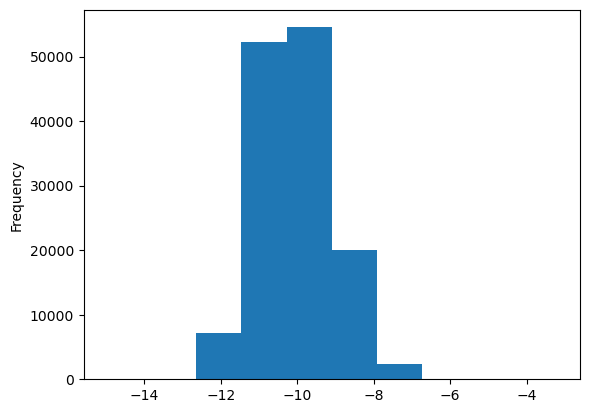

In [12]:
diff_temperature = df["Air temperature [K]"] - df["Process temperature [K]"]
diff_temperature.plot(kind="hist")
df["diff_temperature"] = diff_temperature

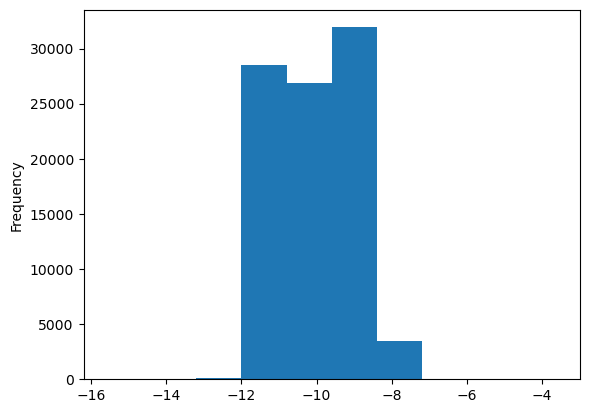

In [13]:
diff_temperature = test_df["Air temperature [K]"] - test_df["Process temperature [K]"]
diff_temperature.plot(kind="hist")
test_df["diff_temperature"] = diff_temperature

* Torque(토크)를 RPM(분당 회전수)으로 나눠  Specific_Torque를 계산합니다.

In [14]:
(df["Rotational speed [rpm]"]==0).sum()

0

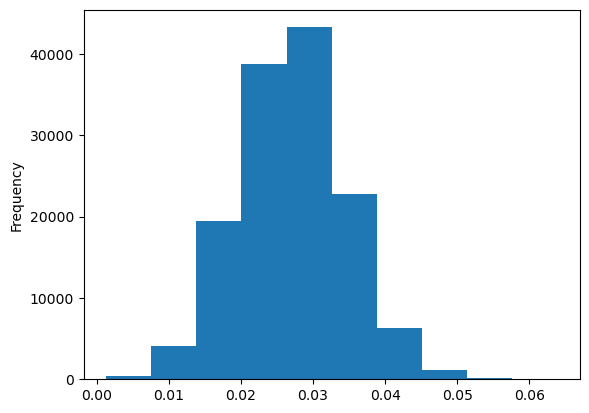

In [15]:
Specific_Torque = df["Torque [Nm]"] / df["Rotational speed [rpm]"]
Specific_Torque.plot(kind="hist")
df["Specific_Torque"] = Specific_Torque

In [16]:
(test_df["Rotational speed [rpm]"]==0).sum()

0

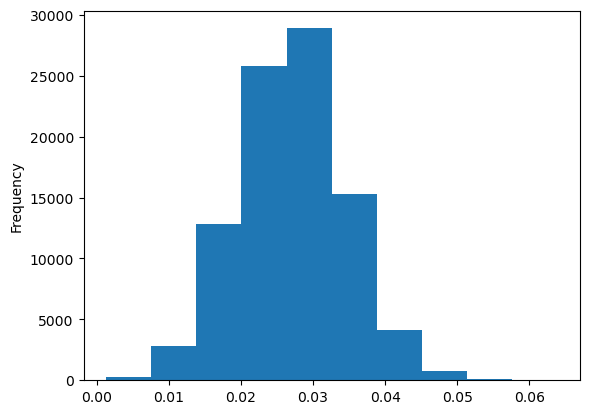

In [17]:
Specific_Torque = test_df["Torque [Nm]"] / test_df["Rotational speed [rpm]"]
Specific_Torque.plot(kind="hist")
test_df["Specific_Torque"] = Specific_Torque

## 2.1 Preprocessing

In [18]:
dfp = feature_engineering.DataFramePreprocessor()
le = LabelEncoder()
stds = StandardScaler()

### 2.1.0 Separate columns

In [19]:
feature_cols = df.columns.difference(['id', 'Product ID', 'Machine failure'])
numeric_cols = df.columns.difference(['id', 'Product ID', 'Machine failure', 'Type'])
continuos_cols = feature_cols.difference(["TWF", "HDF", "PWF", "OSF", "RNF", "Type", "failure_index"])
discrete_cols = feature_cols.difference(continuos_cols)

### 2.1.1 Train set

In [20]:
x_data = df.copy()
x_data = x_data.drop(labels=['id', 'Product ID'], axis=1)
x_data, _ = dfp.fit_transform_multiple_transformer(x_data, [le, stds], [["Type"], continuos_cols])
x_data = pd.concat([x_data, df[discrete_cols.difference(['Type'])]], axis=1)

x_data[discrete_cols] = x_data[discrete_cols].astype("int8")
x_data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Specific_Torque,Tool wear [min],Torque [Nm],diff_temperature,HDF,OSF,PWF,RNF,TWF,failure_index
0,1,0.395880,-0.246230,0.545416,-0.608787,0.556417,-0.499711,1.094793,0,0,0,0,0,0
1,2,1.469856,1.558605,1.720308,-1.432855,1.494433,-1.323028,0.587143,0,0,0,0,0,0
2,1,-0.302204,-1.040358,2.051873,-1.685418,-1.241447,-1.628831,0.891733,0,0,0,0,0,0
3,1,0.610675,0.692284,0.026445,0.265961,1.447532,0.464745,0.181023,0,0,0,0,0,0
4,2,-1.000288,-0.679391,0.869773,-0.750776,-1.100744,-0.582043,-0.935808,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,2,0.127386,1.053251,0.069693,-0.352331,1.650769,-0.335048,-1.240398,0,0,0,0,0,0
136425,0,-1.268781,-1.040358,-0.528565,0.925702,-1.601020,1.029305,-0.935808,0,0,0,0,0,0
136426,1,0.342182,1.342025,0.026445,-0.250242,1.713303,-0.217431,-1.240398,0,0,0,0,0,0
136427,1,0.986567,0.692284,-0.528565,0.663240,-0.975676,0.699979,0.891733,0,0,0,0,0,0


In [21]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     136429 non-null  int8   
 1   Air temperature [K]      136429 non-null  float64
 2   Process temperature [K]  136429 non-null  float64
 3   Rotational speed [rpm]   136429 non-null  float64
 4   Specific_Torque          136429 non-null  float64
 5   Tool wear [min]          136429 non-null  float64
 6   Torque [Nm]              136429 non-null  float64
 7   diff_temperature         136429 non-null  float64
 8   HDF                      136429 non-null  int8   
 9   OSF                      136429 non-null  int8   
 10  PWF                      136429 non-null  int8   
 11  RNF                      136429 non-null  int8   
 12  TWF                      136429 non-null  int8   
 13  failure_index            136429 non-null  int8   
dtypes: f

In [22]:
y_data = df.copy().pop('Machine failure')
y_data = y_data.astype("int8")
y_data

0         0
1         0
2         0
3         0
4         0
         ..
136424    0
136425    0
136426    0
136427    0
136428    0
Name: Machine failure, Length: 136429, dtype: int8

### 2.1.2 Test set

In [23]:
x_test = test_df.copy()
x_test = x_test.drop(labels=['id', 'Product ID'], axis=1)
x_test, _ = dfp.fit_transform_multiple_transformer(x_test, [le, stds], [["Type"], continuos_cols])
x_test = pd.concat([x_test, test_df[discrete_cols.difference(['Type'])]], axis=1)

x_test[discrete_cols] = x_test[discrete_cols].astype("int8")
x_test

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Specific_Torque,Tool wear [min],Torque [Nm],diff_temperature,HDF,OSF,PWF,RNF,TWF,failure_index
0,1,1.313830,1.126570,-0.153806,-0.237133,-0.693494,-0.274579,0.896035,0,0,0,0,0,0
1,1,0.990824,0.765635,1.375097,-1.394808,-1.366729,-1.356341,0.794200,0,0,0,0,0,0
2,1,0.775487,0.332512,0.031949,-0.322412,-0.129855,-0.309854,0.997871,0,0,0,0,0,0
3,2,0.129475,-0.244985,-0.296694,0.689493,-1.554608,0.854217,0.590528,0,0,0,0,0,0
4,2,1.906008,1.704068,-0.039496,0.021924,0.151964,0.113445,1.201543,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,1,1.313830,1.054383,-0.260972,0.016906,-1.398042,0.007620,0.997871,0,0,0,0,0,0
90950,1,-1.054879,-0.100611,0.153403,-0.702318,-1.147536,-0.768427,-1.853531,0,0,0,0,0,0
90951,1,-2.293068,-2.699348,-0.139517,0.065435,1.294897,0.125203,-0.529666,0,0,0,0,0,0
90952,1,-0.947211,-1.544354,0.096248,-0.112254,-0.552584,-0.004138,0.386856,0,0,0,0,0,0


In [24]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90954 entries, 0 to 90953
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     90954 non-null  int8   
 1   Air temperature [K]      90954 non-null  float64
 2   Process temperature [K]  90954 non-null  float64
 3   Rotational speed [rpm]   90954 non-null  float64
 4   Specific_Torque          90954 non-null  float64
 5   Tool wear [min]          90954 non-null  float64
 6   Torque [Nm]              90954 non-null  float64
 7   diff_temperature         90954 non-null  float64
 8   HDF                      90954 non-null  int8   
 9   OSF                      90954 non-null  int8   
 10  PWF                      90954 non-null  int8   
 11  RNF                      90954 non-null  int8   
 12  TWF                      90954 non-null  int8   
 13  failure_index            90954 non-null  int8   
dtypes: float64(7), int8(7)

## 2.2 Feature selecting

### 2.2.1 VIF analysis

In [25]:
fs = feature_engineering.FeatureSelector()

In [26]:
formula_cols = pd.Series(feature_cols).apply(lambda col: f"Q('{col}')")
formula_cols

0         Q('Air temperature [K]')
1                         Q('HDF')
2                         Q('OSF')
3                         Q('PWF')
4     Q('Process temperature [K]')
5                         Q('RNF')
6      Q('Rotational speed [rpm]')
7             Q('Specific_Torque')
8                         Q('TWF')
9             Q('Tool wear [min]')
10                Q('Torque [Nm]')
11                       Q('Type')
12           Q('diff_temperature')
13              Q('failure_index')
dtype: object

In [27]:
formula = "Q('Machine failure')~" + "+".join(formula_cols)
formula+="-1"
formula

"Q('Machine failure')~Q('Air temperature [K]')+Q('HDF')+Q('OSF')+Q('PWF')+Q('Process temperature [K]')+Q('RNF')+Q('Rotational speed [rpm]')+Q('Specific_Torque')+Q('TWF')+Q('Tool wear [min]')+Q('Torque [Nm]')+Q('Type')+Q('diff_temperature')+Q('failure_index')-1"

In [28]:
data = pd.concat([x_data, y_data], axis=1)

In [29]:
fs.vif_analysis(formula, data)

                                  OLS Regression Results                                 
Dep. Variable:     Q('Machine failure')   R-squared (uncentered):                   0.716
Model:                              OLS   Adj. R-squared (uncentered):              0.716
Method:                   Least Squares   F-statistic:                          2.862e+04
Date:                  Mon, 02 Oct 2023   Prob (F-statistic):                        0.00
Time:                          11:45:13   Log-Likelihood:                      1.7540e+05
No. Observations:                136429   AIC:                                 -3.508e+05
Df Residuals:                    136417   BIC:                                 -3.506e+05
Df Model:                            12                                                  
Covariance Type:              nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
---

C:\ProgramData\miniconda3\envs\tf37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                    features   VIF Factor
    Q('Air temperature [K]')          inf
Q('Process temperature [K]')          inf
       Q('diff_temperature')          inf
          Q('failure_index') 4.251954e+08
                    Q('OSF') 2.183521e+08
                    Q('TWF') 4.600094e+07
                    Q('HDF') 4.021209e+07
                    Q('PWF') 7.639379e+06
        Q('Specific_Torque') 7.392811e+01
            Q('Torque [Nm]') 5.311750e+01
 Q('Rotational speed [rpm]') 5.561199e+00
                   Q('Type') 4.592876e+00
        Q('Tool wear [min]') 1.006493e+00
                    Q('RNF') 1.002414e+00
Q('Air temperature [K]') inf
Remove the Q('Air temperature [K]') feature with a VIF greater than 10.
                                  OLS Regression Results                                 
Dep. Variable:     Q('Machine failure')   R-squared (uncentered):                   0.715
Model:                              OLS   Adj. R-squared (uncentered):              0.715

C:\ProgramData\miniconda3\envs\tf37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                    features  VIF Factor
                    Q('HDF')         inf
                    Q('OSF')         inf
                    Q('PWF')         inf
                    Q('TWF')         inf
          Q('failure_index')         inf
        Q('Specific_Torque')   73.915110
            Q('Torque [Nm]')   53.113672
 Q('Rotational speed [rpm]')    5.560503
       Q('diff_temperature')    1.064707
Q('Process temperature [K]')    1.047627
                   Q('Type')    1.011897
        Q('Tool wear [min]')    1.006450
                    Q('RNF')    1.002159
Q('HDF') inf
Remove the Q('HDF') feature with a VIF greater than 10.
                                  OLS Regression Results                                 
Dep. Variable:     Q('Machine failure')   R-squared (uncentered):                   0.715
Model:                              OLS   Adj. R-squared (uncentered):              0.715
Method:                   Least Squares   F-statistic:                          2.858e+

### 2.2.2 Get permutation importance

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)

In [31]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train.values, y_train.values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
fs.get_permutation_importance(dtc, x_valid, y_valid).sort_values("perm_importance")

,feature,perm_importance
8,HDF,0.000000
9,OSF,0.000000
10,PWF,0.000000
12,TWF,0.000000
11,RNF,0.000022
0,Type,0.000153
5,Tool wear [min],0.000502
7,diff_temperature,0.005907
6,Torque [Nm],0.007648
3,Rotational speed [rpm],0.008002


* 위 결과를 바탕으로 우선 RNF값을 제거하고 성능을 평가합니다.
* 그 후 Type에 대해서도 제거를 수행해봅니다.

* 모든 데이터 사용시

In [33]:
# Accuracy: 0.9960052774316499, f1_score: 0.8593548387096774, Roc-Auc: 0.8878698655479385
# Accuracy: 0.9960052774316499, f1_score: 0.858257477243173, Roc-Auc: 0.8835533699108423
# Accuracy: 0.9965916587260867, f1_score: 0.8824273072060682, Roc-Auc: 0.9055905397260844
# Accuracy: 0.9957120867844316, f1_score: 0.845442536327609, Roc-Auc: 0.8719626985611462
# Accuracy: 0.9958218801539307, f1_score: 0.8523316062176166, Roc-Auc: 0.8831892340605477
# array([0.99602724, 0.85956275, 0.88643314])

In [34]:
x_data.drop('RNF', axis=1, inplace=True)
x_test.drop('RNF', axis=1, inplace=True)

* RNF 제거 시 스코어

In [35]:
# Accuracy: 0.9960052774316499, f1_score: 0.8597168597168596, Roc-Auc: 0.8890167495931356
# Accuracy: 0.9960419262625523, f1_score: 0.859375, Roc-Auc: 0.8835719877243662
# Accuracy: 0.9966649563878912, f1_score: 0.883780332056194, Roc-Auc: 0.9021952567006809
# Accuracy: 0.9956021402917247, f1_score: 0.841688654353562, Roc-Auc: 0.8707626722364238
# Accuracy: 0.9958218801539307, f1_score: 0.8523316062176166, Roc-Auc: 0.8831892340605477
# array([0.99602724, 0.85937849, 0.88574718])

* Specific_Torque, Process temperature [K] 제거

In [51]:
x_data.drop(['Process temperature [K]', 'Specific_Torque'], axis=1, inplace=True)
x_test.drop(['Process temperature [K]', 'Specific_Torque'], axis=1, inplace=True)

# 3. Modeling

## 3.1 LogisticRegression

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)

In [35]:
lr = LogisticRegression()
lr.fit(x_train.values, y_train.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
acc_score = lr.score(x_train.values, y_train)
acc_score

0.9960907340624114

In [37]:
f1score = f1_score(y_train, lr.predict(x_train.values))
f1score

0.8592540464461648

In [38]:
acc_score = lr.score(x_valid.values, y_valid)
acc_score

0.9962765333646065

In [39]:
f1score = f1_score(y_valid, lr.predict(x_valid.values))
f1score

0.8672936259143156

## 3.2 XGBoost

In [155]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'gpu_hist',  # GPU 가속 사용
        'gpu_id': 0,  # 사용할 GPU 장치 ID 설정 (0 또는 다른 GPU ID)
        'n_jobs': 4,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_score = []
    valid_logloss = []

    for train_index, test_index in skf.split(x_data, y_data):
        x_train, x_valid = x_data.iloc[train_index], x_data.iloc[test_index]
        y_train, y_valid = y_data.iloc[train_index], y_data.iloc[test_index]

        xgb = XGBClassifier(**params)
        # Early stopping 설정
        xgb.fit(x_train.values, y_train.values, verbose=0, eval_set=[(x_valid.values, y_valid.values)],
                early_stopping_rounds=10)

        acc_score = xgb.score(x_valid, y_valid)
        predict_val = xgb.predict(x_valid)
        f1score = f1_score(y_valid, predict_val)
        roc_auc = roc_auc_score(y_valid, predict_val)
        valid_score.append([acc_score, f1score, roc_auc])
        
        predict_proba_val = xgb.predict_proba(x_valid)[:, 1]
        logloss = log_loss(y_valid, predict_proba_val)
        valid_logloss.append(logloss)

    # Calculate and report the mean F1-score for this trial
    mean_roc_score = np.mean([row[2] for row in valid_score])
    mean_f1_score = np.mean([row[1] for row in valid_score])
    
    # Calculate and report the mean log loss for this trial
    mean_logloss = np.mean(valid_logloss)
    print(f"Mean logloss: {mean_logloss}, Mean F1 score: {mean_f1_score}, Mean ROC AUC: {mean_roc_score}")
    trial.report(mean_logloss, step=trial.number)
    
    return mean_logloss

In [157]:
# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')  # Maximize the F1-score
study.optimize(objective, n_trials=50)  # Number of trials can be adjusted

# Get the best parameters
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Get the best F1-score achieved during the optimization
best_f1_score = study.best_value
print(f"Best F1-Score: {best_f1_score}")

[I 2023-10-02 03:55:07,399] A new study created in memory with name: no-name-febb4c9c-fdbf-440d-97f6-dcfc2ecaef08
[I 2023-10-02 03:55:11,609] Trial 0 finished with value: 0.18724638966374818 and parameters: {'n_estimators': 190, 'max_depth': 9, 'gamma': 0.9464908378574235, 'reg_lambda': 0.327491904057049, 'reg_alpha': 0.24407410143618358, 'min_child_weight': 3.7919667385670306, 'learning_rate': 0.005887244774763535, 'subsample': 0.8197579117964751, 'colsample_bytree': 0.7915644791042991}. Best is trial 0 with value: 0.18724638966374818.


Mean logloss: 0.18724638966374818, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:15,180] Trial 1 finished with value: 0.020610275416059816 and parameters: {'n_estimators': 147, 'max_depth': 17, 'gamma': 0.8815680688457018, 'reg_lambda': 0.4398526412550834, 'reg_alpha': 0.5946135165886322, 'min_child_weight': 7.9787716701542974, 'learning_rate': 0.07980758077897394, 'subsample': 0.6330391709427664, 'colsample_bytree': 0.7158127656788991}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.020610275416059816, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:19,873] Trial 2 finished with value: 0.020977376727918558 and parameters: {'n_estimators': 235, 'max_depth': 12, 'gamma': 0.35169573112473973, 'reg_lambda': 0.19634691543357907, 'reg_alpha': 0.5141715388635865, 'min_child_weight': 7.371752691563768, 'learning_rate': 0.034200521988308044, 'subsample': 0.34703902615413695, 'colsample_bytree': 0.9158835159451618}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.020977376727918558, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:23,046] Trial 3 finished with value: 0.020764218183657583 and parameters: {'n_estimators': 882, 'max_depth': 14, 'gamma': 0.22670385604778054, 'reg_lambda': 0.111218192356632, 'reg_alpha': 0.701812373265436, 'min_child_weight': 6.644844844590381, 'learning_rate': 0.07523271896513202, 'subsample': 0.34141922487943915, 'colsample_bytree': 0.543320461508316}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.020764218183657583, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:30,692] Trial 4 finished with value: 0.36044582364834066 and parameters: {'n_estimators': 279, 'max_depth': 13, 'gamma': 0.1597504862197805, 'reg_lambda': 0.12761444856626036, 'reg_alpha': 0.27766920483124446, 'min_child_weight': 2.6644008443001796, 'learning_rate': 0.0018434206832925889, 'subsample': 0.9517384743326704, 'colsample_bytree': 0.8507907642285815}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.36044582364834066, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:34,369] Trial 5 finished with value: 0.08734392874727605 and parameters: {'n_estimators': 122, 'max_depth': 16, 'gamma': 0.5815450111080962, 'reg_lambda': 0.09863745240183974, 'reg_alpha': 0.19509939353649786, 'min_child_weight': 4.948178812501883, 'learning_rate': 0.015808921525229024, 'subsample': 0.8848850118087577, 'colsample_bytree': 0.9077351179064801}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.08734392874727605, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:41,209] Trial 6 finished with value: 0.14111226385864328 and parameters: {'n_estimators': 362, 'max_depth': 16, 'gamma': 0.5552944892466094, 'reg_lambda': 0.3305432482211804, 'reg_alpha': 0.5415756472093772, 'min_child_weight': 6.52083480587057, 'learning_rate': 0.003914365538036578, 'subsample': 0.3829024635671836, 'colsample_bytree': 0.5972983165272989}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.14111226385864328, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:51,340] Trial 7 finished with value: 0.023106689673994575 and parameters: {'n_estimators': 467, 'max_depth': 7, 'gamma': 0.611284064590543, 'reg_lambda': 0.622936223642203, 'reg_alpha': 0.8553280733036699, 'min_child_weight': 7.199104372257774, 'learning_rate': 0.010217122689905914, 'subsample': 0.969765997703721, 'colsample_bytree': 0.8787191044880055}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.023106689673994575, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:55:57,597] Trial 8 finished with value: 0.33559853424780817 and parameters: {'n_estimators': 419, 'max_depth': 7, 'gamma': 0.8138006083536641, 'reg_lambda': 0.6330943302010876, 'reg_alpha': 0.8661870678128747, 'min_child_weight': 8.226514549437852, 'learning_rate': 0.0013775208276002168, 'subsample': 0.6144633952646178, 'colsample_bytree': 0.817405801523212}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.33559853424780817, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:56:23,465] Trial 9 finished with value: 0.06121799835561169 and parameters: {'n_estimators': 912, 'max_depth': 16, 'gamma': 0.7255474201163863, 'reg_lambda': 0.42771763147965425, 'reg_alpha': 0.675087171991521, 'min_child_weight': 1.0357393979652283, 'learning_rate': 0.0026193684897422016, 'subsample': 0.8069954918458171, 'colsample_bytree': 0.6479216418133741}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.06121799835561169, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:56:29,430] Trial 10 finished with value: 0.020912137461835723 and parameters: {'n_estimators': 669, 'max_depth': 20, 'gamma': 0.977946688946519, 'reg_lambda': 0.9304070267534584, 'reg_alpha': 0.01853429302603149, 'min_child_weight': 10.989261541019845, 'learning_rate': 0.09882147413409363, 'subsample': 0.6244166251584798, 'colsample_bytree': 0.7049716643325407}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.020912137461835723, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:56:32,005] Trial 11 finished with value: 0.02167364100582453 and parameters: {'n_estimators': 983, 'max_depth': 2, 'gamma': 0.3674790821281312, 'reg_lambda': 0.012545262825332415, 'reg_alpha': 0.6905344063393055, 'min_child_weight': 14.48169352398947, 'learning_rate': 0.08478417493109848, 'subsample': 0.4784374690463399, 'colsample_bytree': 0.5055263115281023}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.02167364100582453, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:56:45,535] Trial 12 finished with value: 0.02084176612583205 and parameters: {'n_estimators': 678, 'max_depth': 20, 'gamma': 0.042154160960998416, 'reg_lambda': 0.2387848163597578, 'reg_alpha': 0.9546005746428947, 'min_child_weight': 9.677677909021435, 'learning_rate': 0.04046803998652296, 'subsample': 0.5013697710868771, 'colsample_bytree': 0.7213573410850646}. Best is trial 1 with value: 0.020610275416059816.


Mean logloss: 0.02084176612583205, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:56:52,118] Trial 13 finished with value: 0.020363360928326784 and parameters: {'n_estimators': 816, 'max_depth': 14, 'gamma': 0.3955813533401696, 'reg_lambda': 0.007991626552977249, 'reg_alpha': 0.6858333080734625, 'min_child_weight': 5.340321682123985, 'learning_rate': 0.04729518184287915, 'subsample': 0.6936447124086965, 'colsample_bytree': 0.5235057895288838}. Best is trial 13 with value: 0.020363360928326784.


Mean logloss: 0.020363360928326784, Mean F1 score: 0.8623183069877077, Mean ROC AUC: 0.8816945673751613


[I 2023-10-02 03:57:01,815] Trial 14 finished with value: 0.020571081740158273 and parameters: {'n_estimators': 724, 'max_depth': 17, 'gamma': 0.4164268577808148, 'reg_lambda': 0.5077518606753375, 'reg_alpha': 0.41439615258013623, 'min_child_weight': 3.9657269808954023, 'learning_rate': 0.03239247290750248, 'subsample': 0.7010379153479314, 'colsample_bytree': 0.9896971654048288}. Best is trial 13 with value: 0.020363360928326784.


Mean logloss: 0.020571081740158273, Mean F1 score: 0.8630913185009303, Mean ROC AUC: 0.8828461873847214


[I 2023-10-02 03:57:13,826] Trial 15 finished with value: 0.020474644096182573 and parameters: {'n_estimators': 738, 'max_depth': 10, 'gamma': 0.42462329272697363, 'reg_lambda': 0.5647456831325516, 'reg_alpha': 0.4189500904862704, 'min_child_weight': 4.920285019334814, 'learning_rate': 0.023521588187898214, 'subsample': 0.7289221947415463, 'colsample_bytree': 0.9878493129444104}. Best is trial 13 with value: 0.020363360928326784.


Mean logloss: 0.020474644096182573, Mean F1 score: 0.8626059802849694, Mean ROC AUC: 0.8819271253760522


[I 2023-10-02 03:57:26,233] Trial 16 finished with value: 0.02037507431611902 and parameters: {'n_estimators': 797, 'max_depth': 10, 'gamma': 0.46308174493210646, 'reg_lambda': 0.7023982425359876, 'reg_alpha': 0.42323639600542673, 'min_child_weight': 5.208600177228536, 'learning_rate': 0.021276376118841478, 'subsample': 0.7211600234887527, 'colsample_bytree': 0.6454117983607499}. Best is trial 13 with value: 0.020363360928326784.


Mean logloss: 0.02037507431611902, Mean F1 score: 0.8623185751003399, Mean ROC AUC: 0.8816945672365172


[I 2023-10-02 03:57:33,699] Trial 17 finished with value: 0.02125086050651389 and parameters: {'n_estimators': 562, 'max_depth': 2, 'gamma': 0.4785663718625552, 'reg_lambda': 0.7445004449164891, 'reg_alpha': 0.4145064683060612, 'min_child_weight': 1.8041990969342585, 'learning_rate': 0.015088543684757372, 'subsample': 0.7519891137670032, 'colsample_bytree': 0.6294399441892452}. Best is trial 13 with value: 0.020363360928326784.


Mean logloss: 0.02125086050651389, Mean F1 score: 0.8625439197476801, Mean ROC AUC: 0.8816982909378662


[I 2023-10-02 03:57:38,480] Trial 18 finished with value: 0.02032231351208817 and parameters: {'n_estimators': 828, 'max_depth': 5, 'gamma': 0.28047382376344887, 'reg_lambda': 0.7366320349924604, 'reg_alpha': 0.7672181366061781, 'min_child_weight': 2.819777975793693, 'learning_rate': 0.050221603236010694, 'subsample': 0.6861648392086748, 'colsample_bytree': 0.5588942247982658}. Best is trial 18 with value: 0.02032231351208817.


Mean logloss: 0.02032231351208817, Mean F1 score: 0.8626268973077276, Mean ROC AUC: 0.8819271253760521


[I 2023-10-02 03:57:42,753] Trial 19 finished with value: 0.020356621134261333 and parameters: {'n_estimators': 556, 'max_depth': 5, 'gamma': 0.2562223889352947, 'reg_lambda': 0.8537478099583579, 'reg_alpha': 0.7869841290362141, 'min_child_weight': 2.6001790775934674, 'learning_rate': 0.05063072603149477, 'subsample': 0.5637285939701924, 'colsample_bytree': 0.5547508572097603}. Best is trial 18 with value: 0.02032231351208817.


Mean logloss: 0.020356621134261333, Mean F1 score: 0.8626268973077276, Mean ROC AUC: 0.8819271253760521


[I 2023-10-02 03:57:47,543] Trial 20 finished with value: 0.020365026399133016 and parameters: {'n_estimators': 590, 'max_depth': 5, 'gamma': 0.26835030699264795, 'reg_lambda': 0.8674925692458395, 'reg_alpha': 0.999471072674328, 'min_child_weight': 2.5173312034999564, 'learning_rate': 0.0461130828443234, 'subsample': 0.5369645833148092, 'colsample_bytree': 0.570895693603998}. Best is trial 18 with value: 0.02032231351208817.


Mean logloss: 0.020365026399133016, Mean F1 score: 0.8623175628325814, Mean ROC AUC: 0.8816945673751613


[I 2023-10-02 03:57:51,688] Trial 21 finished with value: 0.020478242677749482 and parameters: {'n_estimators': 824, 'max_depth': 4, 'gamma': 0.2820912610721924, 'reg_lambda': 0.998551837727115, 'reg_alpha': 0.7884919167412047, 'min_child_weight': 3.135147256695273, 'learning_rate': 0.05342377988972109, 'subsample': 0.6654305649046646, 'colsample_bytree': 0.5015526939801079}. Best is trial 18 with value: 0.02032231351208817.


Mean logloss: 0.020478242677749482, Mean F1 score: 0.8630579499600405, Mean ROC AUC: 0.8819345725014619


[I 2023-10-02 03:57:56,589] Trial 22 finished with value: 0.020202295572014802 and parameters: {'n_estimators': 938, 'max_depth': 7, 'gamma': 0.15128196993265705, 'reg_lambda': 0.7526852038219931, 'reg_alpha': 0.7547613244113937, 'min_child_weight': 1.2164152793240657, 'learning_rate': 0.06201039175808002, 'subsample': 0.5807591442524358, 'colsample_bytree': 0.5544588816334155}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020202295572014802, Mean F1 score: 0.8631169064286934, Mean ROC AUC: 0.8828461873847214


[I 2023-10-02 03:58:00,960] Trial 23 finished with value: 0.02023357489648984 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'gamma': 0.06679730499229508, 'reg_lambda': 0.8236696663245024, 'reg_alpha': 0.7675068018253033, 'min_child_weight': 1.2619631871819812, 'learning_rate': 0.05912361815458082, 'subsample': 0.5844982968168453, 'colsample_bytree': 0.5765356472265938}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02023357489648984, Mean F1 score: 0.8624588779967179, Mean ROC AUC: 0.8821522365288216


[I 2023-10-02 03:58:06,034] Trial 24 finished with value: 0.020256364747750506 and parameters: {'n_estimators': 997, 'max_depth': 7, 'gamma': 0.00222666706204519, 'reg_lambda': 0.7714331805632105, 'reg_alpha': 0.9097610903337754, 'min_child_weight': 1.5623488640471088, 'learning_rate': 0.06350364122503377, 'subsample': 0.5897481669256487, 'colsample_bytree': 0.5936632622360476}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020256364747750506, Mean F1 score: 0.8630457245443092, Mean ROC AUC: 0.8826173528078913


[I 2023-10-02 03:58:11,066] Trial 25 finished with value: 0.02022775257834401 and parameters: {'n_estimators': 960, 'max_depth': 8, 'gamma': 0.012254701014588115, 'reg_lambda': 0.7894967583405562, 'reg_alpha': 0.9070509360465921, 'min_child_weight': 1.1535042804257838, 'learning_rate': 0.06733428313550965, 'subsample': 0.5803906123204501, 'colsample_bytree': 0.592532928182583}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02022775257834401, Mean F1 score: 0.8627438074264312, Mean ROC AUC: 0.8823847945297123


[I 2023-10-02 03:58:15,584] Trial 26 finished with value: 0.020298418111549456 and parameters: {'n_estimators': 918, 'max_depth': 8, 'gamma': 0.08228533989602257, 'reg_lambda': 0.8241441963128461, 'reg_alpha': 0.8917840559019012, 'min_child_weight': 1.1071897562057833, 'learning_rate': 0.07496754778539848, 'subsample': 0.4598535532354806, 'colsample_bytree': 0.6079422512743595}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020298418111549456, Mean F1 score: 0.862914302492357, Mean ROC AUC: 0.8821596835155872


[I 2023-10-02 03:58:17,934] Trial 27 finished with value: 0.020332848511640494 and parameters: {'n_estimators': 946, 'max_depth': 4, 'gamma': 0.11853822199795452, 'reg_lambda': 0.6731784921090527, 'reg_alpha': 0.989011675979736, 'min_child_weight': 1.6688832320073015, 'learning_rate': 0.09850441327139571, 'subsample': 0.551045582891722, 'colsample_bytree': 0.656360481420258}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020332848511640494, Mean F1 score: 0.8623981734600991, Mean ROC AUC: 0.8819234018133473


[I 2023-10-02 03:58:30,265] Trial 28 finished with value: 0.020317680839773984 and parameters: {'n_estimators': 879, 'max_depth': 9, 'gamma': 0.15151650861104057, 'reg_lambda': 0.9250371552897731, 'reg_alpha': 0.8326851626666796, 'min_child_weight': 1.0676410898537956, 'learning_rate': 0.02823977005844086, 'subsample': 0.5972407998899799, 'colsample_bytree': 0.678544199631222}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020317680839773984, Mean F1 score: 0.8636148899145804, Mean ROC AUC: 0.8830824689483169


[I 2023-10-02 03:58:37,003] Trial 29 finished with value: 0.020460326227446403 and parameters: {'n_estimators': 990, 'max_depth': 8, 'gamma': 0.025546543928373328, 'reg_lambda': 0.7953555065349366, 'reg_alpha': 0.9283332964813337, 'min_child_weight': 3.872538838684835, 'learning_rate': 0.03578720068684186, 'subsample': 0.5057279559314949, 'colsample_bytree': 0.5820513846978693}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020460326227446403, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:58:41,422] Trial 30 finished with value: 0.02050290815612893 and parameters: {'n_estimators': 870, 'max_depth': 11, 'gamma': 0.09182281045418572, 'reg_lambda': 0.6876267520204289, 'reg_alpha': 0.7533567535912933, 'min_child_weight': 3.487691447495441, 'learning_rate': 0.06220552104967785, 'subsample': 0.4374026037331998, 'colsample_bytree': 0.7567122419513234}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02050290815612893, Mean F1 score: 0.8625441878603123, Mean ROC AUC: 0.8816982907992221


[I 2023-10-02 03:58:45,686] Trial 31 finished with value: 0.02026581736874144 and parameters: {'n_estimators': 993, 'max_depth': 6, 'gamma': 0.030290097844949737, 'reg_lambda': 0.7555267350019057, 'reg_alpha': 0.9151798024023473, 'min_child_weight': 2.117251078810178, 'learning_rate': 0.06242464871342644, 'subsample': 0.5844028138805506, 'colsample_bytree': 0.6072866266677985}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02026581736874144, Mean F1 score: 0.8626830156734309, Mean ROC AUC: 0.8821559599528823


[I 2023-10-02 03:58:50,504] Trial 32 finished with value: 0.020261101589768408 and parameters: {'n_estimators': 952, 'max_depth': 7, 'gamma': 0.027898582240154225, 'reg_lambda': 0.7768979804976709, 'reg_alpha': 0.8374297645882383, 'min_child_weight': 2.0495408532825645, 'learning_rate': 0.06475597964421352, 'subsample': 0.6306503460140669, 'colsample_bytree': 0.5414562019337765}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020261101589768408, Mean F1 score: 0.8630513085360629, Mean ROC AUC: 0.8826173526692471


[I 2023-10-02 03:58:54,706] Trial 33 finished with value: 0.020298256117156195 and parameters: {'n_estimators': 930, 'max_depth': 9, 'gamma': 0.004434486932395228, 'reg_lambda': 0.833036717422846, 'reg_alpha': 0.9299599549733654, 'min_child_weight': 1.6573810210140356, 'learning_rate': 0.09894271937048561, 'subsample': 0.6487544101515317, 'colsample_bytree': 0.5820100054856724}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020298256117156195, Mean F1 score: 0.8623809691590237, Mean ROC AUC: 0.8819234018133473


[I 2023-10-02 03:58:59,371] Trial 34 finished with value: 0.0206971991113857 and parameters: {'n_estimators': 999, 'max_depth': 3, 'gamma': 0.18264632552828297, 'reg_lambda': 0.8894237091195264, 'reg_alpha': 0.6280403478235741, 'min_child_weight': 3.498480586290581, 'learning_rate': 0.0384511736678853, 'subsample': 0.5388137299596147, 'colsample_bytree': 0.5380774149043326}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.0206971991113857, Mean F1 score: 0.8630579499600405, Mean ROC AUC: 0.8819345725014619


[I 2023-10-02 03:59:03,564] Trial 35 finished with value: 0.020279359700539512 and parameters: {'n_estimators': 758, 'max_depth': 6, 'gamma': 0.09909829135650425, 'reg_lambda': 0.7966916950163387, 'reg_alpha': 0.8850175910925359, 'min_child_weight': 2.2611401051019504, 'learning_rate': 0.06827520364144953, 'subsample': 0.5950309001190736, 'colsample_bytree': 0.6113357024480753}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020279359700539512, Mean F1 score: 0.8625395619905062, Mean ROC AUC: 0.8823810709670076


[I 2023-10-02 03:59:17,489] Trial 36 finished with value: 0.02028772257085732 and parameters: {'n_estimators': 868, 'max_depth': 11, 'gamma': 0.1952568090380094, 'reg_lambda': 0.7292440704385902, 'reg_alpha': 0.8129263703158885, 'min_child_weight': 1.0072767647214633, 'learning_rate': 0.02853342753808055, 'subsample': 0.6572977301198437, 'colsample_bytree': 0.5769401201974832}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02028772257085732, Mean F1 score: 0.862311332427997, Mean ROC AUC: 0.882377347820235


[I 2023-10-02 03:59:22,543] Trial 37 finished with value: 0.02033076423726628 and parameters: {'n_estimators': 903, 'max_depth': 8, 'gamma': 0.13817390192494036, 'reg_lambda': 0.6439033124901001, 'reg_alpha': 0.7289751050453774, 'min_child_weight': 4.18892119301291, 'learning_rate': 0.060019755872622566, 'subsample': 0.5769628456651675, 'colsample_bytree': 0.5244243029919049}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02033076423726628, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:59:25,834] Trial 38 finished with value: 0.02040825804673024 and parameters: {'n_estimators': 854, 'max_depth': 6, 'gamma': 0.07261133217764351, 'reg_lambda': 0.5964455324067794, 'reg_alpha': 0.7381891776903068, 'min_child_weight': 2.9640550640030936, 'learning_rate': 0.07740159753422468, 'subsample': 0.5193348473384451, 'colsample_bytree': 0.6169319558769556}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02040825804673024, Mean F1 score: 0.8631929013048666, Mean ROC AUC: 0.882392241655122


[I 2023-10-02 03:59:32,170] Trial 39 finished with value: 0.020409151397070044 and parameters: {'n_estimators': 201, 'max_depth': 10, 'gamma': 0.19946567468205012, 'reg_lambda': 0.6915510910318635, 'reg_alpha': 0.8440606860677966, 'min_child_weight': 1.9470844974607697, 'learning_rate': 0.041878483935492566, 'subsample': 0.4376637984380419, 'colsample_bytree': 0.5894580063802075}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020409151397070044, Mean F1 score: 0.8623185751003399, Mean ROC AUC: 0.8816945672365172


[I 2023-10-02 03:59:53,219] Trial 40 finished with value: 0.020636216749823612 and parameters: {'n_estimators': 949, 'max_depth': 7, 'gamma': 0.13972618406994664, 'reg_lambda': 0.79268796183251, 'reg_alpha': 0.6068811230989912, 'min_child_weight': 3.4221631907962866, 'learning_rate': 0.007647180510194834, 'subsample': 0.5681886125580551, 'colsample_bytree': 0.5645178803076031}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020636216749823612, Mean F1 score: 0.862770544775411, Mean ROC AUC: 0.8817020143619269


[I 2023-10-02 03:59:57,957] Trial 41 finished with value: 0.02029452067760764 and parameters: {'n_estimators': 958, 'max_depth': 7, 'gamma': 0.006981929362611334, 'reg_lambda': 0.7733881543925534, 'reg_alpha': 0.8315514943575651, 'min_child_weight': 1.8251876751430305, 'learning_rate': 0.06753880900207795, 'subsample': 0.6360551029377244, 'colsample_bytree': 0.542807535581258}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02029452067760764, Mean F1 score: 0.86327234957204, Mean ROC AUC: 0.882621076231952


[I 2023-10-02 04:00:03,803] Trial 42 finished with value: 0.020274388200546865 and parameters: {'n_estimators': 939, 'max_depth': 8, 'gamma': 0.05972992913117118, 'reg_lambda': 0.814705364171902, 'reg_alpha': 0.8686459202354259, 'min_child_weight': 2.608643060893103, 'learning_rate': 0.055984823478206214, 'subsample': 0.6045758879745472, 'colsample_bytree': 0.5292822953188897}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020274388200546865, Mean F1 score: 0.862914302492357, Mean ROC AUC: 0.8821596835155872


[I 2023-10-02 04:00:07,124] Trial 43 finished with value: 0.02030061468238628 and parameters: {'n_estimators': 898, 'max_depth': 4, 'gamma': 0.00340210242726785, 'reg_lambda': 0.892720033904224, 'reg_alpha': 0.9452909057579519, 'min_child_weight': 1.5131170083666836, 'learning_rate': 0.08038151261013576, 'subsample': 0.6259262375838746, 'colsample_bytree': 0.5486680382425568}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02030061468238628, Mean F1 score: 0.8627056745697306, Mean ROC AUC: 0.8821559599528822


[I 2023-10-02 04:00:16,170] Trial 44 finished with value: 0.020383742747950507 and parameters: {'n_estimators': 782, 'max_depth': 12, 'gamma': 0.0634634258740148, 'reg_lambda': 0.7613638971107628, 'reg_alpha': 0.8027611955197582, 'min_child_weight': 2.1406989577321496, 'learning_rate': 0.03937324243748573, 'subsample': 0.5492922949630279, 'colsample_bytree': 0.6311287708703126}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020383742747950507, Mean F1 score: 0.862663770794373, Mean ROC AUC: 0.8821559599528822


[I 2023-10-02 04:00:19,511] Trial 45 finished with value: 0.02021896326332869 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'gamma': 0.10577548902106286, 'reg_lambda': 0.8475487490782956, 'reg_alpha': 0.8869994019030099, 'min_child_weight': 1.1166374572570803, 'learning_rate': 0.08224591101551743, 'subsample': 0.6090620409650616, 'colsample_bytree': 0.5927765674681802}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02021896326332869, Mean F1 score: 0.86327234957204, Mean ROC AUC: 0.882621076231952


[I 2023-10-02 04:00:22,902] Trial 46 finished with value: 0.020299761389073596 and parameters: {'n_estimators': 969, 'max_depth': 6, 'gamma': 0.11355686605261142, 'reg_lambda': 0.956489557858749, 'reg_alpha': 0.8856203316253786, 'min_child_weight': 1.2989009167357746, 'learning_rate': 0.08553147144198972, 'subsample': 0.5965576971448777, 'colsample_bytree': 0.5962851999563797}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020299761389073596, Mean F1 score: 0.8638006909719678, Mean ROC AUC: 0.8828573579341917


[I 2023-10-02 04:00:26,734] Trial 47 finished with value: 0.020470684281984848 and parameters: {'n_estimators': 655, 'max_depth': 3, 'gamma': 0.22300624428714608, 'reg_lambda': 0.850588354346671, 'reg_alpha': 0.6668235263928461, 'min_child_weight': 1.0633323233728025, 'learning_rate': 0.05094561273134156, 'subsample': 0.5169352237384648, 'colsample_bytree': 0.6626916223402468}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.020470684281984848, Mean F1 score: 0.8631397575661957, Mean ROC AUC: 0.882163407216936


[I 2023-10-02 04:00:30,746] Trial 48 finished with value: 0.02043751762439469 and parameters: {'n_estimators': 346, 'max_depth': 9, 'gamma': 0.16347685842761583, 'reg_lambda': 0.9042943385710064, 'reg_alpha': 0.9641760284876187, 'min_child_weight': 2.819738998415442, 'learning_rate': 0.08329190304074034, 'subsample': 0.48409490982483794, 'colsample_bytree': 0.6792538615754904}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02043751762439469, Mean F1 score: 0.862318128641118, Mean ROC AUC: 0.8816945672365174


[I 2023-10-02 04:00:35,976] Trial 49 finished with value: 0.02043955002619982 and parameters: {'n_estimators': 998, 'max_depth': 5, 'gamma': 0.10656242877519204, 'reg_lambda': 0.858923742540857, 'reg_alpha': 0.9104545875143422, 'min_child_weight': 4.6366382901910725, 'learning_rate': 0.04264300879788568, 'subsample': 0.6587966698458817, 'colsample_bytree': 0.6354062457289987}. Best is trial 22 with value: 0.020202295572014802.


Mean logloss: 0.02043955002619982, Mean F1 score: 0.8630579499600405, Mean ROC AUC: 0.8819345725014619
Best Parameters: {'n_estimators': 938, 'max_depth': 7, 'gamma': 0.15128196993265705, 'reg_lambda': 0.7526852038219931, 'reg_alpha': 0.7547613244113937, 'min_child_weight': 1.2164152793240657, 'learning_rate': 0.06201039175808002, 'subsample': 0.5807591442524358, 'colsample_bytree': 0.5544588816334155}
Best F1-Score: 0.020202295572014802


### 3.2.1 Create submission.csv

In [158]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)

In [159]:
xgb = XGBClassifier(**study.best_params)
xgb.fit(x_train.values, y_train.values, verbose=2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5544588816334155, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.15128196993265705, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.06201039175808002, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=1.2164152793240657, missing=nan,
              monotone_constraints='()', n_estimators=938, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0.7547613244113937, ...)

In [160]:
cols = x_train.columns

In [161]:
fis = xgb.feature_importances_

In [162]:
fi = pd.DataFrame(fis, index=cols, columns=["Feature_importance"])
fi.sort_values("Feature_importance", ascending=False)

,Feature_importance
HDF,0.334606
failure_index,0.210199
OSF,0.169002
PWF,0.153703
TWF,0.114126
Torque [Nm],0.002704
Rotational speed [rpm],0.002671
Tool wear [min],0.002521
Specific_Torque,0.002380
diff_temperature,0.002237


In [163]:
prediction = xgb.predict_proba(x_test)[:,1]
len(prediction)

90954

In [164]:
result = test_df.copy()
result = result.drop(result.columns.difference(['id']), axis=1)
result['Machine failure'] = prediction
result

,id,Machine failure
0,136429,0.000154
1,136430,0.002452
2,136431,0.000016
3,136432,0.000022
4,136433,0.013607
...,...,...
90949,227378,0.000042
90950,227379,0.000179
90951,227380,0.000236
90952,227381,0.000017


In [165]:
result.to_csv('../data/submission.csv', index = False)

## 3.3 TensorFlow

In [53]:
# 특정 epoch 마다 출력할 Callback 정의
class VerboseEpochs(Callback):
    def __init__(self, verbose_epoch_interval):
        super(VerboseEpochs, self).__init__()
        self.verbose_epoch_interval = verbose_epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.verbose_epoch_interval == 0:
#             print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']} - acc: {logs['binary_accuracy']}")
            print(f"Epoch {epoch + 1}/{self.params['epochs']} - val_loss: {logs['val_loss']} - val_acc: {logs['val_binary_accuracy']}")

# Callback 객체 생성
verbose_callback = VerboseEpochs(verbose_epoch_interval=10)  # 예를 들어, 매 5 epoch 마다 출력

In [61]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.00005, restore_best_weights=True)

In [62]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data, random_state=42)

In [65]:
# 로그 설정
logging.basicConfig(filename='optuna_trials.log', level=logging.INFO)
    
def objective(trial):
    # 하이퍼파라미터 추천
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 512, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    # 뉴런 수 감소 비율 튜닝 (예: 1.0에서 0.3 사이)
    neuron_reduction_rate = trial.suggest_float('neuron_reduction_rate', 0.3, 1)
    # 드롭아웃 비율 튜닝 (예: 0.0에서 0.5 사이)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    
    f1_scores = []  # 각 폴드의 F1 스코어를 저장할 리스트

    # 모델 구성
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(x_data.shape[1],)))

    for i in range(1, num_hidden_layers):
        num_units = int(num_units * neuron_reduction_rate)  # 뉴런 수 감소
        model.add(Dense(num_units, activation='relu'))

        model.add(Dropout(dropout_rate))  # 드롭아웃 레이어 추가 및 드롭아웃 비율 조정

        model.add(BatchNormalization())  # 배치 정규화 레이어 추가
    model.add(Dense(1, activation='sigmoid'))

    # 모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['binary_accuracy'])

    # 모델 훈련 및 평가
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid),
                        callbacks=[early_stopping, verbose_callback], batch_size=128, verbose=0)

    # 검증 데이터에 대한 예측을 생성
    y_pred = model.predict(x_valid)
    y_pred = (y_pred > 0.5).astype(int)

    # F1 스코어 계산 및 저장
    val_f1_score = f1_score(y_valid, y_pred)
    val_loss = min(history.history['val_loss'])

    # 트라이얼 리포트    
    print(f"val_loss: {val_loss}, F1 score: {val_f1_score}")
    trial.report(val_f1_score, step=trial.number)
#     logging.info(f"Trial {trial.number}: F1 Score = {val_f1_score}")
    
    return val_loss

In [66]:
study = optuna.create_study(direction='minimize')  # 최대화 문제로 설정
study.optimize(objective, n_trials=100)  # n_trials은 시도할 하이퍼파라미터 조합의 수

best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

[I 2023-10-02 12:17:04,803] A new study created in memory with name: no-name-13bed4e4-ea3d-469c-ac6c-15a02ccbb2a0


Epoch 1/100 - val_loss: 0.04454023018479347 - val_acc: 0.9961885809898376
Epoch 11/100 - val_loss: 0.024320613592863083 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.024140432476997375 - val_acc: 0.9962765574455261


[I 2023-10-02 12:18:36,256] Trial 0 finished with value: 0.02344880998134613 and parameters: {'num_hidden_layers': 2, 'num_units': 77, 'learning_rate': 0.00047839847323936203, 'neuron_reduction_rate': 0.46184315597126047, 'dropout_rate': 0.45558856838805284}. Best is trial 0 with value: 0.02344880998134613.


val_loss: 0.02344880998134613, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.02605561353266239 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.02471226453781128 - val_acc: 0.9963351488113403


[I 2023-10-02 12:19:17,821] Trial 1 finished with value: 0.023315828293561935 and parameters: {'num_hidden_layers': 2, 'num_units': 202, 'learning_rate': 0.08913252909154454, 'neuron_reduction_rate': 0.9408118657471747, 'dropout_rate': 0.05934572240399605}. Best is trial 1 with value: 0.023315828293561935.


val_loss: 0.023315828293561935, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.026293113827705383 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.02656708098948002 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.024738263338804245 - val_acc: 0.9963351488113403
Epoch 31/100 - val_loss: 0.02341304160654545 - val_acc: 0.9963351488113403


[I 2023-10-02 12:22:16,048] Trial 2 finished with value: 0.022591453045606613 and parameters: {'num_hidden_layers': 3, 'num_units': 138, 'learning_rate': 0.07585671627953171, 'neuron_reduction_rate': 0.7252429456198279, 'dropout_rate': 0.06526713142728985}. Best is trial 2 with value: 0.022591453045606613.


val_loss: 0.022591453045606613, F1 score: 0.8696558915537018
Epoch 1/100 - val_loss: 0.18084147572517395 - val_acc: 0.9960126876831055
Epoch 11/100 - val_loss: 0.022669410333037376 - val_acc: 0.9961885809898376
Epoch 21/100 - val_loss: 0.023265471681952477 - val_acc: 0.9962472319602966


[I 2023-10-02 12:24:04,462] Trial 3 finished with value: 0.022634491324424744 and parameters: {'num_hidden_layers': 3, 'num_units': 89, 'learning_rate': 0.00033623918304549494, 'neuron_reduction_rate': 0.3241805831310249, 'dropout_rate': 0.012361260486070336}. Best is trial 2 with value: 0.022591453045606613.


val_loss: 0.022634491324424744, F1 score: 0.8654244306418218
Epoch 1/100 - val_loss: 0.031073343008756638 - val_acc: 0.9944881200790405
Epoch 11/100 - val_loss: 0.02282170206308365 - val_acc: 0.996042013168335


[I 2023-10-02 12:25:10,485] Trial 4 finished with value: 0.02260296232998371 and parameters: {'num_hidden_layers': 2, 'num_units': 319, 'learning_rate': 0.001113318070468151, 'neuron_reduction_rate': 0.600385526737487, 'dropout_rate': 0.0011532924917277976}. Best is trial 2 with value: 0.022591453045606613.


val_loss: 0.02260296232998371, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.023875771090388298 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022927293553948402 - val_acc: 0.9961299300193787
Epoch 21/100 - val_loss: 0.022770032286643982 - val_acc: 0.9963058233261108


[I 2023-10-02 12:26:38,782] Trial 5 finished with value: 0.022560754790902138 and parameters: {'num_hidden_layers': 2, 'num_units': 196, 'learning_rate': 0.013164457117258823, 'neuron_reduction_rate': 0.5462402458401965, 'dropout_rate': 0.16981392974290865}. Best is trial 5 with value: 0.022560754790902138.


val_loss: 0.022560754790902138, F1 score: 0.8624612202688728
Epoch 1/100 - val_loss: 0.030235737562179565 - val_acc: 0.9951037764549255
Epoch 11/100 - val_loss: 0.0225230623036623 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.022750306874513626 - val_acc: 0.9962179064750671
Epoch 31/100 - val_loss: 0.022286221385002136 - val_acc: 0.9961299300193787


[I 2023-10-02 12:27:50,405] Trial 6 finished with value: 0.022036878392100334 and parameters: {'num_hidden_layers': 1, 'num_units': 48, 'learning_rate': 0.0008627695661508799, 'neuron_reduction_rate': 0.47642491357625727, 'dropout_rate': 0.0782421648829989}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022036878392100334, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.0348266139626503 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02338491380214691 - val_acc: 0.9963351488113403


[I 2023-10-02 12:29:25,933] Trial 7 finished with value: 0.02293389104306698 and parameters: {'num_hidden_layers': 3, 'num_units': 376, 'learning_rate': 0.0005242160136781646, 'neuron_reduction_rate': 0.34612548167847557, 'dropout_rate': 0.1591156632631378}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02293389104306698, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.025363758206367493 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.022503433749079704 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.022238681092858315 - val_acc: 0.9962179064750671


[I 2023-10-02 12:30:21,112] Trial 8 finished with value: 0.02215372957289219 and parameters: {'num_hidden_layers': 1, 'num_units': 41, 'learning_rate': 0.0029964877981707924, 'neuron_reduction_rate': 0.6317374912264101, 'dropout_rate': 0.08190380201237607}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02215372957289219, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.0243680477142334 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.035305608063936234 - val_acc: 0.9963351488113403


[I 2023-10-02 12:31:24,696] Trial 9 finished with value: 0.02356567233800888 and parameters: {'num_hidden_layers': 2, 'num_units': 371, 'learning_rate': 0.046721691327080005, 'neuron_reduction_rate': 0.9851043308039598, 'dropout_rate': 0.4990464121731544}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02356567233800888, F1 score: 0.8696558915537018
Epoch 1/100 - val_loss: 0.6413801908493042 - val_acc: 0.5774891376495361
Epoch 11/100 - val_loss: 0.05238978937268257 - val_acc: 0.987041175365448
Epoch 21/100 - val_loss: 0.028400765731930733 - val_acc: 0.995250403881073
Epoch 31/100 - val_loss: 0.02475244551897049 - val_acc: 0.9961885809898376
Epoch 41/100 - val_loss: 0.02408033423125744 - val_acc: 0.9961885809898376
Epoch 51/100 - val_loss: 0.02373635768890381 - val_acc: 0.9962765574455261
Epoch 61/100 - val_loss: 0.023502612486481667 - val_acc: 0.9963058233261108
Epoch 71/100 - val_loss: 0.023354772478342056 - val_acc: 0.9963351488113403
Epoch 81/100 - val_loss: 0.023242857307195663 - val_acc: 0.9963351488113403
Epoch 91/100 - val_loss: 0.023169277235865593 - val_acc: 0.9963351488113403


[I 2023-10-02 12:34:47,250] Trial 10 finished with value: 0.023099441081285477 and parameters: {'num_hidden_layers': 1, 'num_units': 36, 'learning_rate': 3.765912980361255e-05, 'neuron_reduction_rate': 0.741850594379545, 'dropout_rate': 0.2958062150541231}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.023099441081285477, F1 score: 0.8696558915537018
Epoch 1/100 - val_loss: 0.02422410435974598 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.02238391898572445 - val_acc: 0.9961885809898376


[I 2023-10-02 12:35:20,944] Trial 11 finished with value: 0.022072818130254745 and parameters: {'num_hidden_layers': 1, 'num_units': 35, 'learning_rate': 0.003912207219592807, 'neuron_reduction_rate': 0.4851731490749556, 'dropout_rate': 0.12381474871254143}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022072818130254745, F1 score: 0.8696558915537018
Epoch 1/100 - val_loss: 0.023666175082325935 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.022184932604432106 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.02284937910735607 - val_acc: 0.9962765574455261


[I 2023-10-02 12:36:22,395] Trial 12 finished with value: 0.022094612941145897 and parameters: {'num_hidden_layers': 1, 'num_units': 52, 'learning_rate': 0.003069872645146707, 'neuron_reduction_rate': 0.44701516941882935, 'dropout_rate': 0.15595889489096396}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022094612941145897, F1 score: 0.8663212435233161
Epoch 1/100 - val_loss: 0.27407515048980713 - val_acc: 0.985575258731842
Epoch 11/100 - val_loss: 0.025739191100001335 - val_acc: 0.9962179064750671
Epoch 21/100 - val_loss: 0.023935502395033836 - val_acc: 0.9962472319602966
Epoch 31/100 - val_loss: 0.023311171680688858 - val_acc: 0.9963058233261108
Epoch 41/100 - val_loss: 0.02306857891380787 - val_acc: 0.9963058233261108
Epoch 51/100 - val_loss: 0.022897500544786453 - val_acc: 0.9963058233261108
Epoch 61/100 - val_loss: 0.022763356566429138 - val_acc: 0.9963058233261108
Epoch 71/100 - val_loss: 0.022665100172162056 - val_acc: 0.9963058233261108
Epoch 81/100 - val_loss: 0.02261362224817276 - val_acc: 0.9962765574455261


[I 2023-10-02 12:39:21,109] Trial 13 finished with value: 0.022567646577954292 and parameters: {'num_hidden_layers': 1, 'num_units': 34, 'learning_rate': 0.00010470367395647523, 'neuron_reduction_rate': 0.47485661763561887, 'dropout_rate': 0.2581356218835762}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022567646577954292, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024281064048409462 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.026517663151025772 - val_acc: 0.9961006045341492
Epoch 21/100 - val_loss: 0.02263374999165535 - val_acc: 0.9961006045341492


[I 2023-10-02 12:40:14,674] Trial 14 finished with value: 0.022085975855588913 and parameters: {'num_hidden_layers': 1, 'num_units': 56, 'learning_rate': 0.0071099852932135525, 'neuron_reduction_rate': 0.39371806442491386, 'dropout_rate': 0.12085101182703423}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022085975855588913, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.6671680212020874 - val_acc: 0.562771201133728
Epoch 11/100 - val_loss: 0.18300789594650269 - val_acc: 0.9842559099197388
Epoch 21/100 - val_loss: 0.08014944940805435 - val_acc: 0.9842559099197388
Epoch 31/100 - val_loss: 0.0558282807469368 - val_acc: 0.9856045246124268
Epoch 41/100 - val_loss: 0.044043608009815216 - val_acc: 0.990324854850769
Epoch 51/100 - val_loss: 0.03626570105552673 - val_acc: 0.9929928183555603
Epoch 61/100 - val_loss: 0.03114224225282669 - val_acc: 0.9943708181381226
Epoch 71/100 - val_loss: 0.027968335896730423 - val_acc: 0.9950158596038818
Epoch 81/100 - val_loss: 0.026133907958865166 - val_acc: 0.9954849481582642
Epoch 91/100 - val_loss: 0.025140225887298584 - val_acc: 0.995924711227417


[I 2023-10-02 12:43:36,393] Trial 15 finished with value: 0.024633441120386124 and parameters: {'num_hidden_layers': 1, 'num_units': 32, 'learning_rate': 1.1998729924431998e-05, 'neuron_reduction_rate': 0.3026498138513486, 'dropout_rate': 0.209332645011217}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.024633441120386124, F1 score: 0.8649214659685863
Epoch 1/100 - val_loss: 0.025234777480363846 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022699231281876564 - val_acc: 0.9960712790489197
Epoch 21/100 - val_loss: 0.022425277158617973 - val_acc: 0.9961885809898376


[I 2023-10-02 12:44:37,588] Trial 16 finished with value: 0.022160816937685013 and parameters: {'num_hidden_layers': 1, 'num_units': 55, 'learning_rate': 0.0016270012959010288, 'neuron_reduction_rate': 0.536576607997579, 'dropout_rate': 0.10789796871001427}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022160816937685013, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.02471998892724514 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022612519562244415 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.022833064198493958 - val_acc: 0.9961006045341492


[I 2023-10-02 12:45:20,936] Trial 17 finished with value: 0.022612519562244415 and parameters: {'num_hidden_layers': 1, 'num_units': 70, 'learning_rate': 0.015929628566979676, 'neuron_reduction_rate': 0.4057638589100473, 'dropout_rate': 0.22337610004623448}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022612519562244415, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.12249390035867691 - val_acc: 0.984314501285553
Epoch 11/100 - val_loss: 0.024331629276275635 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02319428138434887 - val_acc: 0.9963058233261108
Epoch 31/100 - val_loss: 0.02292783185839653 - val_acc: 0.9963058233261108
Epoch 41/100 - val_loss: 0.02280327118933201 - val_acc: 0.9962472319602966
Epoch 51/100 - val_loss: 0.022685879841446877 - val_acc: 0.9962179064750671
Epoch 61/100 - val_loss: 0.022480987012386322 - val_acc: 0.9962472319602966
Epoch 71/100 - val_loss: 0.022502414882183075 - val_acc: 0.9961299300193787


[I 2023-10-02 12:47:44,130] Trial 18 finished with value: 0.02245822176337242 and parameters: {'num_hidden_layers': 1, 'num_units': 48, 'learning_rate': 0.0001626326671865141, 'neuron_reduction_rate': 0.5207702994554383, 'dropout_rate': 0.05467669397143365}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02245822176337242, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.024772556498646736 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02326684072613716 - val_acc: 0.9960712790489197
Epoch 21/100 - val_loss: 0.023044221103191376 - val_acc: 0.9963058233261108


[I 2023-10-02 12:49:18,439] Trial 19 finished with value: 0.02256854623556137 and parameters: {'num_hidden_layers': 2, 'num_units': 42, 'learning_rate': 0.0017617498885079965, 'neuron_reduction_rate': 0.39305284727124556, 'dropout_rate': 0.12495347594590273}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02256854623556137, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.023028843104839325 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.023106759414076805 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.022541075944900513 - val_acc: 0.9963058233261108
Epoch 31/100 - val_loss: 0.022458797320723534 - val_acc: 0.9962472319602966


[I 2023-10-02 12:50:24,634] Trial 20 finished with value: 0.02209077961742878 and parameters: {'num_hidden_layers': 1, 'num_units': 94, 'learning_rate': 0.004389455387366142, 'neuron_reduction_rate': 0.5839239445641665, 'dropout_rate': 0.0011265836640427518}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02209077961742878, F1 score: 0.8663212435233161
Epoch 1/100 - val_loss: 0.023237319663167 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022243792191147804 - val_acc: 0.996042013168335
Epoch 21/100 - val_loss: 0.022304140031337738 - val_acc: 0.9961299300193787


[I 2023-10-02 12:51:10,286] Trial 21 finished with value: 0.02214750088751316 and parameters: {'num_hidden_layers': 1, 'num_units': 60, 'learning_rate': 0.005792664339290028, 'neuron_reduction_rate': 0.38390948526555946, 'dropout_rate': 0.11958175164086932}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02214750088751316, F1 score: 0.8645294725956567
Epoch 1/100 - val_loss: 0.024485750123858452 - val_acc: 0.996042013168335
Epoch 11/100 - val_loss: 0.022282354533672333 - val_acc: 0.9963351488113403


[I 2023-10-02 12:51:48,984] Trial 22 finished with value: 0.02220458909869194 and parameters: {'num_hidden_layers': 1, 'num_units': 47, 'learning_rate': 0.008962586246827203, 'neuron_reduction_rate': 0.4718388980952226, 'dropout_rate': 0.1062462612426008}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.02220458909869194, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.02444428950548172 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.023373423144221306 - val_acc: 0.9962179064750671


[I 2023-10-02 12:52:24,571] Trial 23 finished with value: 0.022307008504867554 and parameters: {'num_hidden_layers': 1, 'num_units': 32, 'learning_rate': 0.02106615981952428, 'neuron_reduction_rate': 0.40643653993385076, 'dropout_rate': 0.044745368905120396}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022307008504867554, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.0278460830450058 - val_acc: 0.9956315159797668
Epoch 11/100 - val_loss: 0.02226746268570423 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.022104226052761078 - val_acc: 0.9961592555046082


[I 2023-10-02 12:53:20,616] Trial 24 finished with value: 0.022104226052761078 and parameters: {'num_hidden_layers': 1, 'num_units': 60, 'learning_rate': 0.0008371522646415205, 'neuron_reduction_rate': 0.5073732552343416, 'dropout_rate': 0.08990160189382976}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022104226052761078, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.02294049970805645 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.0253096092492342 - val_acc: 0.9961299300193787


[I 2023-10-02 12:54:22,530] Trial 25 finished with value: 0.022586476057767868 and parameters: {'num_hidden_layers': 2, 'num_units': 43, 'learning_rate': 0.005664033668672585, 'neuron_reduction_rate': 0.3453964387416979, 'dropout_rate': 0.143299777922491}. Best is trial 6 with value: 0.022036878392100334.


val_loss: 0.022586476057767868, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024805672466754913 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.02302679233253002 - val_acc: 0.9960712790489197


[I 2023-10-02 12:55:03,352] Trial 26 finished with value: 0.022018104791641235 and parameters: {'num_hidden_layers': 1, 'num_units': 67, 'learning_rate': 0.002042573426426388, 'neuron_reduction_rate': 0.43397865204127134, 'dropout_rate': 0.16970278697886598}. Best is trial 26 with value: 0.022018104791641235.


val_loss: 0.022018104791641235, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.02475476637482643 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022155780345201492 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.022534001618623734 - val_acc: 0.9962472319602966


[I 2023-10-02 12:55:55,810] Trial 27 finished with value: 0.02208586409687996 and parameters: {'num_hidden_layers': 1, 'num_units': 71, 'learning_rate': 0.0020435076234805363, 'neuron_reduction_rate': 0.457405338101798, 'dropout_rate': 0.17766082274053321}. Best is trial 26 with value: 0.022018104791641235.


val_loss: 0.02208586409687996, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.024639379233121872 - val_acc: 0.9961885809898376
Epoch 11/100 - val_loss: 0.023057959973812103 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.023405369371175766 - val_acc: 0.9962765574455261


[I 2023-10-02 12:57:25,899] Trial 28 finished with value: 0.02269291691482067 and parameters: {'num_hidden_layers': 2, 'num_units': 40, 'learning_rate': 0.001220479108269261, 'neuron_reduction_rate': 0.5631191092135737, 'dropout_rate': 0.20527761607896183}. Best is trial 26 with value: 0.022018104791641235.


val_loss: 0.02269291691482067, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.032328490167856216 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.023728495463728905 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.02306368760764599 - val_acc: 0.9961592555046082


[I 2023-10-02 12:58:44,121] Trial 29 finished with value: 0.022779196500778198 and parameters: {'num_hidden_layers': 2, 'num_units': 82, 'learning_rate': 0.0005866998770130997, 'neuron_reduction_rate': 0.44655459431563405, 'dropout_rate': 0.32483621905614773}. Best is trial 26 with value: 0.022018104791641235.


val_loss: 0.022779196500778198, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.023783408105373383 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022387461736798286 - val_acc: 0.9961299300193787
Epoch 21/100 - val_loss: 0.022585030645132065 - val_acc: 0.9961885809898376
Epoch 31/100 - val_loss: 0.022528046742081642 - val_acc: 0.9960126876831055


[I 2023-10-02 12:59:54,627] Trial 30 finished with value: 0.022000640630722046 and parameters: {'num_hidden_layers': 1, 'num_units': 67, 'learning_rate': 0.003106017233153293, 'neuron_reduction_rate': 0.5056100727223402, 'dropout_rate': 0.08539571905542977}. Best is trial 30 with value: 0.022000640630722046.


val_loss: 0.022000640630722046, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.024396361783146858 - val_acc: 0.9961885809898376
Epoch 11/100 - val_loss: 0.02236730419099331 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.02202683687210083 - val_acc: 0.9962179064750671


[I 2023-10-02 13:00:48,471] Trial 31 finished with value: 0.021999899297952652 and parameters: {'num_hidden_layers': 1, 'num_units': 67, 'learning_rate': 0.002454208658963119, 'neuron_reduction_rate': 0.503312371048423, 'dropout_rate': 0.08362672778683106}. Best is trial 31 with value: 0.021999899297952652.


val_loss: 0.021999899297952652, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.024278735741972923 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.02202432230114937 - val_acc: 0.9962179064750671


[I 2023-10-02 13:01:29,205] Trial 32 finished with value: 0.022008702158927917 and parameters: {'num_hidden_layers': 1, 'num_units': 102, 'learning_rate': 0.0022723054043305014, 'neuron_reduction_rate': 0.504773820704614, 'dropout_rate': 0.05527372590621914}. Best is trial 31 with value: 0.021999899297952652.


val_loss: 0.022008702158927917, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.02393415942788124 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022990090772509575 - val_acc: 0.9961592555046082


[I 2023-10-02 13:02:08,599] Trial 33 finished with value: 0.022114956751465797 and parameters: {'num_hidden_layers': 1, 'num_units': 106, 'learning_rate': 0.0020847358571503562, 'neuron_reduction_rate': 0.5208768800857091, 'dropout_rate': 0.027563849026625176}. Best is trial 31 with value: 0.021999899297952652.


val_loss: 0.022114956751465797, F1 score: 0.8624612202688728
Epoch 1/100 - val_loss: 0.024064024910330772 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022500567138195038 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.02335822954773903 - val_acc: 0.995866060256958


[I 2023-10-02 13:03:04,494] Trial 34 finished with value: 0.021957015618681908 and parameters: {'num_hidden_layers': 1, 'num_units': 73, 'learning_rate': 0.003182190390405751, 'neuron_reduction_rate': 0.6781441728822644, 'dropout_rate': 0.03860226292891291}. Best is trial 34 with value: 0.021957015618681908.


val_loss: 0.021957015618681908, F1 score: 0.8624612202688728
Epoch 1/100 - val_loss: 0.025689903646707535 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.023818369954824448 - val_acc: 0.9961006045341492


[I 2023-10-02 13:04:02,689] Trial 35 finished with value: 0.0224677212536335 and parameters: {'num_hidden_layers': 3, 'num_units': 112, 'learning_rate': 0.0035193520945160056, 'neuron_reduction_rate': 0.6942366502441567, 'dropout_rate': 0.03948397445430858}. Best is trial 34 with value: 0.021957015618681908.


val_loss: 0.0224677212536335, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.026445887982845306 - val_acc: 0.9961006045341492
Epoch 11/100 - val_loss: 0.022904587909579277 - val_acc: 0.995983362197876


[I 2023-10-02 13:04:57,081] Trial 36 finished with value: 0.0221065916121006 and parameters: {'num_hidden_layers': 2, 'num_units': 81, 'learning_rate': 0.007863494704712155, 'neuron_reduction_rate': 0.6315219246376216, 'dropout_rate': 0.06632775380042177}. Best is trial 34 with value: 0.021957015618681908.


val_loss: 0.0221065916121006, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.024920126423239708 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.02226063422858715 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.022491727024316788 - val_acc: 0.9963058233261108


[I 2023-10-02 13:05:59,028] Trial 37 finished with value: 0.021929707378149033 and parameters: {'num_hidden_layers': 1, 'num_units': 145, 'learning_rate': 0.0011062054301570624, 'neuron_reduction_rate': 0.5671658260468588, 'dropout_rate': 0.02412268740673379}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.021929707378149033, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.025572333484888077 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022970011457800865 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02229912020266056 - val_acc: 0.9962472319602966


[I 2023-10-02 13:06:44,692] Trial 38 finished with value: 0.02206278033554554 and parameters: {'num_hidden_layers': 1, 'num_units': 136, 'learning_rate': 0.0009654969105614154, 'neuron_reduction_rate': 0.5933186022375593, 'dropout_rate': 0.018534327617392116}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.02206278033554554, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.04501643776893616 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022749299183487892 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02279317006468773 - val_acc: 0.9961299300193787


[I 2023-10-02 13:07:56,127] Trial 39 finished with value: 0.022749299183487892 and parameters: {'num_hidden_layers': 2, 'num_units': 123, 'learning_rate': 0.0002982547258088451, 'neuron_reduction_rate': 0.6829544169807775, 'dropout_rate': 0.025297620169278574}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022749299183487892, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.02749747224152088 - val_acc: 0.9957194924354553
Epoch 11/100 - val_loss: 0.022624077275395393 - val_acc: 0.9960126876831055
Epoch 21/100 - val_loss: 0.022316472604870796 - val_acc: 0.9961885809898376


[I 2023-10-02 13:08:50,309] Trial 40 finished with value: 0.022110695019364357 and parameters: {'num_hidden_layers': 1, 'num_units': 167, 'learning_rate': 0.000601340942931793, 'neuron_reduction_rate': 0.557257747388116, 'dropout_rate': 0.0002971167324349461}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022110695019364357, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.02511441893875599 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.02210884727537632 - val_acc: 0.9962179064750671
Epoch 21/100 - val_loss: 0.02227962575852871 - val_acc: 0.9962472319602966


[I 2023-10-02 13:09:40,197] Trial 41 finished with value: 0.022033771499991417 and parameters: {'num_hidden_layers': 1, 'num_units': 91, 'learning_rate': 0.001237914477273644, 'neuron_reduction_rate': 0.6192669400865115, 'dropout_rate': 0.06033676858965591}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022033771499991417, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.025080956518650055 - val_acc: 0.9959540367126465
Epoch 11/100 - val_loss: 0.02225215546786785 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.022416913881897926 - val_acc: 0.9963058233261108


[I 2023-10-02 13:10:40,199] Trial 42 finished with value: 0.022147390991449356 and parameters: {'num_hidden_layers': 1, 'num_units': 98, 'learning_rate': 0.002921588895881259, 'neuron_reduction_rate': 0.5766487753053701, 'dropout_rate': 0.0757996449734725}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022147390991449356, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.02513282746076584 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022347193211317062 - val_acc: 0.9961885809898376


[I 2023-10-02 13:11:21,697] Trial 43 finished with value: 0.022240033373236656 and parameters: {'num_hidden_layers': 1, 'num_units': 74, 'learning_rate': 0.0014646865457840616, 'neuron_reduction_rate': 0.5036603295935024, 'dropout_rate': 0.038216317548157484}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022240033373236656, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.025328118354082108 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022532567381858826 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.022546475753188133 - val_acc: 0.9961885809898376


[I 2023-10-02 13:12:14,112] Trial 44 finished with value: 0.02216259390115738 and parameters: {'num_hidden_layers': 1, 'num_units': 84, 'learning_rate': 0.002344112235204669, 'neuron_reduction_rate': 0.5464129781001361, 'dropout_rate': 0.08930069572593931}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.02216259390115738, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.02335170842707157 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.023069988936185837 - val_acc: 0.9962472319602966


[I 2023-10-02 13:13:35,312] Trial 45 finished with value: 0.022714845836162567 and parameters: {'num_hidden_layers': 3, 'num_units': 155, 'learning_rate': 0.0033501201077952717, 'neuron_reduction_rate': 0.7582741444078653, 'dropout_rate': 0.0589168984649159}. Best is trial 37 with value: 0.021929707378149033.


val_loss: 0.022714845836162567, F1 score: 0.8636363636363636
Epoch 1/100 - val_loss: 0.023157324641942978 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.021618224680423737 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.023085258901119232 - val_acc: 0.9961006045341492


[I 2023-10-02 13:14:18,881] Trial 46 finished with value: 0.021618224680423737 and parameters: {'num_hidden_layers': 1, 'num_units': 119, 'learning_rate': 0.004539933342427342, 'neuron_reduction_rate': 0.6555737972200745, 'dropout_rate': 0.022351766593534536}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021618224680423737, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.023363901302218437 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022982565686106682 - val_acc: 0.996042013168335
Epoch 21/100 - val_loss: 0.022182321175932884 - val_acc: 0.9962472319602966


[I 2023-10-02 13:15:04,965] Trial 47 finished with value: 0.022182321175932884 and parameters: {'num_hidden_layers': 1, 'num_units': 114, 'learning_rate': 0.010739934313777648, 'neuron_reduction_rate': 0.677874238160158, 'dropout_rate': 0.017259685378750667}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022182321175932884, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.023832036182284355 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.023509060963988304 - val_acc: 0.9962179064750671


[I 2023-10-02 13:15:40,710] Trial 48 finished with value: 0.021902156993746758 and parameters: {'num_hidden_layers': 1, 'num_units': 209, 'learning_rate': 0.004550370220550466, 'neuron_reduction_rate': 0.6137084851454988, 'dropout_rate': 0.029417224487621997}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021902156993746758, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.024218877777457237 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.02311280369758606 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02275814302265644 - val_acc: 0.996042013168335


[I 2023-10-02 13:16:38,398] Trial 49 finished with value: 0.022197812795639038 and parameters: {'num_hidden_layers': 1, 'num_units': 234, 'learning_rate': 0.0045953141584468525, 'neuron_reduction_rate': 0.6084917787524542, 'dropout_rate': 0.022373144958243617}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022197812795639038, F1 score: 0.8654244306418218
Epoch 1/100 - val_loss: 0.023198919370770454 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.023307010531425476 - val_acc: 0.9961299300193787


[I 2023-10-02 13:17:20,183] Trial 50 finished with value: 0.022012392058968544 and parameters: {'num_hidden_layers': 1, 'num_units': 205, 'learning_rate': 0.005549811472257407, 'neuron_reduction_rate': 0.6388127136637987, 'dropout_rate': 0.00037745526171010374}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022012392058968544, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.023441307246685028 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02215404435992241 - val_acc: 0.9961592555046082
Epoch 21/100 - val_loss: 0.023252936080098152 - val_acc: 0.9962179064750671


[I 2023-10-02 13:18:04,331] Trial 51 finished with value: 0.022115351632237434 and parameters: {'num_hidden_layers': 1, 'num_units': 134, 'learning_rate': 0.0034915411709568077, 'neuron_reduction_rate': 0.6561786629463309, 'dropout_rate': 0.04269576663183236}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022115351632237434, F1 score: 0.8642487046632125
Epoch 1/100 - val_loss: 0.023353004828095436 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02556033246219158 - val_acc: 0.9961592555046082


[I 2023-10-02 13:18:44,182] Trial 52 finished with value: 0.022164151072502136 and parameters: {'num_hidden_layers': 1, 'num_units': 66, 'learning_rate': 0.00761151161562299, 'neuron_reduction_rate': 0.5947119600020382, 'dropout_rate': 0.07730600202053849}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022164151072502136, F1 score: 0.8624612202688728
Epoch 1/100 - val_loss: 0.026096781715750694 - val_acc: 0.9957781434059143
Epoch 11/100 - val_loss: 0.02393610216677189 - val_acc: 0.9958953857421875


[I 2023-10-02 13:19:17,472] Trial 53 finished with value: 0.021983491256833076 and parameters: {'num_hidden_layers': 1, 'num_units': 77, 'learning_rate': 0.012017509099602485, 'neuron_reduction_rate': 0.5399116226287161, 'dropout_rate': 0.09370367653746724}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021983491256833076, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.02593121863901615 - val_acc: 0.9959540367126465
Epoch 11/100 - val_loss: 0.022743722423911095 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.025349076837301254 - val_acc: 0.9962472319602966


[I 2023-10-02 13:20:05,412] Trial 54 finished with value: 0.022323904559016228 and parameters: {'num_hidden_layers': 1, 'num_units': 121, 'learning_rate': 0.016324099059835936, 'neuron_reduction_rate': 0.7241034875681662, 'dropout_rate': 0.03425889995429009}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022323904559016228, F1 score: 0.8636363636363636
Epoch 1/100 - val_loss: 0.02740238979458809 - val_acc: 0.9958367347717285
Epoch 11/100 - val_loss: 0.022815799340605736 - val_acc: 0.9960712790489197
Epoch 21/100 - val_loss: 0.02363665960729122 - val_acc: 0.9959540367126465


[I 2023-10-02 13:21:01,229] Trial 55 finished with value: 0.022606471553444862 and parameters: {'num_hidden_layers': 1, 'num_units': 87, 'learning_rate': 0.022511387735904196, 'neuron_reduction_rate': 0.568377337083898, 'dropout_rate': 0.053021077094395186}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022606471553444862, F1 score: 0.8636363636363636
Epoch 1/100 - val_loss: 0.023612001910805702 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.023213420063257217 - val_acc: 0.9962472319602966


[I 2023-10-02 13:21:42,370] Trial 56 finished with value: 0.02188561111688614 and parameters: {'num_hidden_layers': 1, 'num_units': 96, 'learning_rate': 0.005467800641417157, 'neuron_reduction_rate': 0.6531575550580159, 'dropout_rate': 0.0975645381824407}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02188561111688614, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.024353820830583572 - val_acc: 0.9961299300193787
Epoch 11/100 - val_loss: 0.022452564910054207 - val_acc: 0.9962765574455261


[I 2023-10-02 13:22:23,938] Trial 57 finished with value: 0.022452564910054207 and parameters: {'num_hidden_layers': 1, 'num_units': 99, 'learning_rate': 0.009627445385358622, 'neuron_reduction_rate': 0.6530059566229591, 'dropout_rate': 0.10005196316278528}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022452564910054207, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.023981843143701553 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.02261316403746605 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.02205769345164299 - val_acc: 0.9963058233261108


[I 2023-10-02 13:23:09,418] Trial 58 finished with value: 0.022003885358572006 and parameters: {'num_hidden_layers': 1, 'num_units': 77, 'learning_rate': 0.00485258843324301, 'neuron_reduction_rate': 0.6134222528847351, 'dropout_rate': 0.01672151587235201}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022003885358572006, F1 score: 0.8633540372670808
Epoch 1/100 - val_loss: 0.02441740408539772 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.024970324710011482 - val_acc: 0.996042013168335


[I 2023-10-02 13:23:41,625] Trial 59 finished with value: 0.02225777506828308 and parameters: {'num_hidden_layers': 1, 'num_units': 149, 'learning_rate': 0.010818132276952337, 'neuron_reduction_rate': 0.6596841586703213, 'dropout_rate': 0.03864158958407369}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02225777506828308, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.024649716913700104 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.02232212759554386 - val_acc: 0.9962472319602966


[I 2023-10-02 13:24:18,871] Trial 60 finished with value: 0.021912848576903343 and parameters: {'num_hidden_layers': 1, 'num_units': 116, 'learning_rate': 0.006377055219517952, 'neuron_reduction_rate': 0.6213679211083878, 'dropout_rate': 0.06626801863694465}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021912848576903343, F1 score: 0.8681204569055035
Epoch 1/100 - val_loss: 0.024521781131625175 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.02289666421711445 - val_acc: 0.9962179064750671


[I 2023-10-02 13:25:01,133] Trial 61 finished with value: 0.02203434891998768 and parameters: {'num_hidden_layers': 1, 'num_units': 112, 'learning_rate': 0.006434619118160076, 'neuron_reduction_rate': 0.6195166594983011, 'dropout_rate': 0.0658495118245177}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02203434891998768, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.025470362976193428 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022922413423657417 - val_acc: 0.995983362197876


[I 2023-10-02 13:25:29,054] Trial 62 finished with value: 0.02244909107685089 and parameters: {'num_hidden_layers': 1, 'num_units': 92, 'learning_rate': 0.0043533664697687526, 'neuron_reduction_rate': 0.7086359119885323, 'dropout_rate': 0.10079923814841112}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02244909107685089, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.023580994457006454 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.02334713190793991 - val_acc: 0.996042013168335
Epoch 21/100 - val_loss: 0.02254238724708557 - val_acc: 0.9961299300193787


[I 2023-10-02 13:26:13,794] Trial 63 finished with value: 0.022320562973618507 and parameters: {'num_hidden_layers': 1, 'num_units': 126, 'learning_rate': 0.00634965864418142, 'neuron_reduction_rate': 0.5832282655225113, 'dropout_rate': 0.012513225760018138}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022320562973618507, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.026423463597893715 - val_acc: 0.9958953857421875
Epoch 11/100 - val_loss: 0.02282254956662655 - val_acc: 0.9963058233261108


[I 2023-10-02 13:26:51,786] Trial 64 finished with value: 0.022225316613912582 and parameters: {'num_hidden_layers': 1, 'num_units': 105, 'learning_rate': 0.01577486107318145, 'neuron_reduction_rate': 0.7554202481180571, 'dropout_rate': 0.0728978675448965}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022225316613912582, F1 score: 0.8681204569055035
Epoch 1/100 - val_loss: 0.024782005697488785 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022413909435272217 - val_acc: 0.995983362197876
Epoch 21/100 - val_loss: 0.02222185581922531 - val_acc: 0.996042013168335
Epoch 31/100 - val_loss: 0.022253653034567833 - val_acc: 0.9963058233261108


[I 2023-10-02 13:27:57,485] Trial 65 finished with value: 0.021983619779348373 and parameters: {'num_hidden_layers': 1, 'num_units': 89, 'learning_rate': 0.0015648602064508626, 'neuron_reduction_rate': 0.6398017518930688, 'dropout_rate': 0.052113216509249334}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021983619779348373, F1 score: 0.8645294725956567
Epoch 1/100 - val_loss: 0.023307379335165024 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022265775129199028 - val_acc: 0.9961592555046082


[I 2023-10-02 13:28:33,103] Trial 66 finished with value: 0.022054390981793404 and parameters: {'num_hidden_layers': 1, 'num_units': 77, 'learning_rate': 0.004105797792268857, 'neuron_reduction_rate': 0.5483609723949561, 'dropout_rate': 0.13675670268526233}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022054390981793404, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.02405714802443981 - val_acc: 0.9961885809898376
Epoch 11/100 - val_loss: 0.02314663492143154 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.023241350427269936 - val_acc: 0.9960712790489197


[I 2023-10-02 13:29:29,524] Trial 67 finished with value: 0.02244858630001545 and parameters: {'num_hidden_layers': 1, 'num_units': 145, 'learning_rate': 0.012072667685988041, 'neuron_reduction_rate': 0.611752245431794, 'dropout_rate': 0.030719889424006372}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02244858630001545, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.023968229070305824 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022552987560629845 - val_acc: 0.9961006045341492
Epoch 21/100 - val_loss: 0.022589528933167458 - val_acc: 0.9962765574455261


[I 2023-10-02 13:30:21,353] Trial 68 finished with value: 0.021942755207419395 and parameters: {'num_hidden_layers': 1, 'num_units': 173, 'learning_rate': 0.007498458485550412, 'neuron_reduction_rate': 0.6714383786872908, 'dropout_rate': 0.11210693728272321}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021942755207419395, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.025453902781009674 - val_acc: 0.9957781434059143
Epoch 11/100 - val_loss: 0.024106241762638092 - val_acc: 0.9963351488113403
Epoch 21/100 - val_loss: 0.023012744262814522 - val_acc: 0.9960712790489197


[I 2023-10-02 13:31:13,581] Trial 69 finished with value: 0.022269107401371002 and parameters: {'num_hidden_layers': 1, 'num_units': 169, 'learning_rate': 0.007682675968562488, 'neuron_reduction_rate': 0.670989281444342, 'dropout_rate': 0.10457761121083557}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022269107401371002, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.025243904441595078 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.0232387725263834 - val_acc: 0.9963058233261108


[I 2023-10-02 13:32:20,136] Trial 70 finished with value: 0.023162376135587692 and parameters: {'num_hidden_layers': 3, 'num_units': 141, 'learning_rate': 0.005861408767910468, 'neuron_reduction_rate': 0.6952616594091094, 'dropout_rate': 0.11729253923994297}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.023162376135587692, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.0240637119859457 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022756338119506836 - val_acc: 0.9962765574455261


[I 2023-10-02 13:32:57,600] Trial 71 finished with value: 0.022255536168813705 and parameters: {'num_hidden_layers': 1, 'num_units': 129, 'learning_rate': 0.008889376355824425, 'neuron_reduction_rate': 0.6441903521142565, 'dropout_rate': 0.07201512340464476}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022255536168813705, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024870706722140312 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.02236977219581604 - val_acc: 0.9962472319602966


[I 2023-10-02 13:33:31,333] Trial 72 finished with value: 0.022192610427737236 and parameters: {'num_hidden_layers': 1, 'num_units': 99, 'learning_rate': 0.00259749506455983, 'neuron_reduction_rate': 0.6716838553981618, 'dropout_rate': 0.04806794390705578}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022192610427737236, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024770770221948624 - val_acc: 0.9961006045341492
Epoch 11/100 - val_loss: 0.022249462082982063 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.023047378286719322 - val_acc: 0.9961006045341492


[I 2023-10-02 13:34:15,260] Trial 73 finished with value: 0.02221721224486828 and parameters: {'num_hidden_layers': 1, 'num_units': 118, 'learning_rate': 0.005165725193687092, 'neuron_reduction_rate': 0.5954525835680269, 'dropout_rate': 0.08683823597802429}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02221721224486828, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.023775000125169754 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.02259213849902153 - val_acc: 0.9962179064750671


[I 2023-10-02 13:34:54,639] Trial 74 finished with value: 0.021863451227545738 and parameters: {'num_hidden_layers': 1, 'num_units': 184, 'learning_rate': 0.002851387381094741, 'neuron_reduction_rate': 0.6255842949460516, 'dropout_rate': 0.028845612540143967}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021863451227545738, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.024268433451652527 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022615890949964523 - val_acc: 0.9960712790489197


[I 2023-10-02 13:35:36,154] Trial 75 finished with value: 0.022171033546328545 and parameters: {'num_hidden_layers': 1, 'num_units': 175, 'learning_rate': 0.0017893678421279494, 'neuron_reduction_rate': 0.6386163616120799, 'dropout_rate': 0.00962350711602761}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022171033546328545, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.02491798996925354 - val_acc: 0.9961885809898376
Epoch 11/100 - val_loss: 0.02216930501163006 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.023143194615840912 - val_acc: 0.9961006045341492


[I 2023-10-02 13:36:48,351] Trial 76 finished with value: 0.02216930501163006 and parameters: {'num_hidden_layers': 2, 'num_units': 190, 'learning_rate': 0.0028698787088427976, 'neuron_reduction_rate': 0.7121503020525647, 'dropout_rate': 0.027432634217738106}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02216930501163006, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.0235945675522089 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.022138891741633415 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.023352626711130142 - val_acc: 0.9960126876831055


[I 2023-10-02 13:37:33,515] Trial 77 finished with value: 0.022138891741633415 and parameters: {'num_hidden_layers': 1, 'num_units': 242, 'learning_rate': 0.004057619829040215, 'neuron_reduction_rate': 0.6226827366591339, 'dropout_rate': 0.06056197100243567}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022138891741633415, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024713968858122826 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022586237639188766 - val_acc: 0.9962765574455261


[I 2023-10-02 13:38:11,228] Trial 78 finished with value: 0.02216259203851223 and parameters: {'num_hidden_layers': 1, 'num_units': 162, 'learning_rate': 0.0012858175306714168, 'neuron_reduction_rate': 0.6632837868252419, 'dropout_rate': 0.04323511945143485}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02216259203851223, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.025281688198447227 - val_acc: 0.9961299300193787
Epoch 11/100 - val_loss: 0.022360770031809807 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02353663742542267 - val_acc: 0.9960712790489197


[I 2023-10-02 13:39:21,956] Trial 79 finished with value: 0.022360770031809807 and parameters: {'num_hidden_layers': 2, 'num_units': 152, 'learning_rate': 0.002540518400915569, 'neuron_reduction_rate': 0.6886875179430145, 'dropout_rate': 0.030573999203674113}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022360770031809807, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.024251794442534447 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022404106333851814 - val_acc: 0.9962179064750671


[I 2023-10-02 13:40:00,834] Trial 80 finished with value: 0.02203998900949955 and parameters: {'num_hidden_layers': 1, 'num_units': 136, 'learning_rate': 0.0034072955559380446, 'neuron_reduction_rate': 0.5800079256352386, 'dropout_rate': 0.009135182226841343}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02203998900949955, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.023184238001704216 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.02256125956773758 - val_acc: 0.9961299300193787
Epoch 21/100 - val_loss: 0.022253723815083504 - val_acc: 0.9963351488113403


[I 2023-10-02 13:41:01,388] Trial 81 finished with value: 0.022253723815083504 and parameters: {'num_hidden_layers': 1, 'num_units': 108, 'learning_rate': 0.007286455484398533, 'neuron_reduction_rate': 0.6035019216889698, 'dropout_rate': 0.09174613275282632}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022253723815083504, F1 score: 0.8627450980392157
Epoch 1/100 - val_loss: 0.024915898218750954 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.022347941994667053 - val_acc: 0.9962472319602966


[I 2023-10-02 13:41:41,749] Trial 82 finished with value: 0.022193921729922295 and parameters: {'num_hidden_layers': 1, 'num_units': 130, 'learning_rate': 0.008976862811990472, 'neuron_reduction_rate': 0.5306031603553103, 'dropout_rate': 0.06477068604082245}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022193921729922295, F1 score: 0.8615702479338844
Epoch 1/100 - val_loss: 0.023629531264305115 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022318575531244278 - val_acc: 0.9962765574455261
Epoch 21/100 - val_loss: 0.022468267008662224 - val_acc: 0.9962179064750671


[I 2023-10-02 13:42:25,316] Trial 83 finished with value: 0.022318575531244278 and parameters: {'num_hidden_layers': 1, 'num_units': 180, 'learning_rate': 0.004633574280190315, 'neuron_reduction_rate': 0.6274023494910551, 'dropout_rate': 0.050920449647001056}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022318575531244278, F1 score: 0.8681204569055035
Epoch 1/100 - val_loss: 0.024281853809952736 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022715849801898003 - val_acc: 0.995983362197876


[I 2023-10-02 13:43:00,754] Trial 84 finished with value: 0.02225903980433941 and parameters: {'num_hidden_layers': 1, 'num_units': 157, 'learning_rate': 0.0020641746918058017, 'neuron_reduction_rate': 0.5634061921430936, 'dropout_rate': 0.024904614223576323}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02225903980433941, F1 score: 0.8597938144329897
Epoch 1/100 - val_loss: 0.023214176297187805 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022223204374313354 - val_acc: 0.9963058233261108


[I 2023-10-02 13:43:38,011] Trial 85 finished with value: 0.022058432921767235 and parameters: {'num_hidden_layers': 1, 'num_units': 141, 'learning_rate': 0.0063009062670318665, 'neuron_reduction_rate': 0.6440829308684536, 'dropout_rate': 0.07717771971599136}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022058432921767235, F1 score: 0.8624612202688728
Epoch 1/100 - val_loss: 0.023988664150238037 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022619932889938354 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.02196545898914337 - val_acc: 0.9963058233261108
Epoch 31/100 - val_loss: 0.022761337459087372 - val_acc: 0.995983362197876


[I 2023-10-02 13:44:41,444] Trial 86 finished with value: 0.02196545898914337 and parameters: {'num_hidden_layers': 1, 'num_units': 120, 'learning_rate': 0.0036843350502125116, 'neuron_reduction_rate': 0.587232379645601, 'dropout_rate': 0.1113899816501143}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02196545898914337, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.02392319217324257 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.023479871451854706 - val_acc: 0.9962179064750671
Epoch 21/100 - val_loss: 0.022331250831484795 - val_acc: 0.9963058233261108


[I 2023-10-02 13:45:28,984] Trial 87 finished with value: 0.02226082608103752 and parameters: {'num_hidden_layers': 1, 'num_units': 121, 'learning_rate': 0.003711396207124799, 'neuron_reduction_rate': 0.587217076100079, 'dropout_rate': 0.11335691752472915}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02226082608103752, F1 score: 0.8681204569055035
Epoch 1/100 - val_loss: 0.024165792390704155 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022630367428064346 - val_acc: 0.995983362197876
Epoch 21/100 - val_loss: 0.02301769144833088 - val_acc: 0.9961006045341492


[I 2023-10-02 13:46:21,113] Trial 88 finished with value: 0.022130778059363365 and parameters: {'num_hidden_layers': 1, 'num_units': 111, 'learning_rate': 0.0017226719964386127, 'neuron_reduction_rate': 0.6635042914936485, 'dropout_rate': 0.12706485409282486}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022130778059363365, F1 score: 0.8660436137071651
Epoch 1/100 - val_loss: 0.023595811799168587 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.023386551067233086 - val_acc: 0.9959540367126465


[I 2023-10-02 13:47:01,250] Trial 89 finished with value: 0.02237127535045147 and parameters: {'num_hidden_layers': 1, 'num_units': 147, 'learning_rate': 0.0031201223855726293, 'neuron_reduction_rate': 0.6033919277297337, 'dropout_rate': 0.0421495995831218}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02237127535045147, F1 score: 0.86875
Epoch 1/100 - val_loss: 0.027620388194918633 - val_acc: 0.996042013168335
Epoch 11/100 - val_loss: 0.022669831290841103 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.022085977718234062 - val_acc: 0.9961885809898376
Epoch 31/100 - val_loss: 0.022287840023636818 - val_acc: 0.9962472319602966


[I 2023-10-02 13:48:04,112] Trial 90 finished with value: 0.022085977718234062 and parameters: {'num_hidden_layers': 1, 'num_units': 94, 'learning_rate': 0.0008115311914570466, 'neuron_reduction_rate': 0.6304761473563703, 'dropout_rate': 0.0008719217594111532}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022085977718234062, F1 score: 0.8651452282157676
Epoch 1/100 - val_loss: 0.023327093571424484 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02207200787961483 - val_acc: 0.9962472319602966


[I 2023-10-02 13:48:37,973] Trial 91 finished with value: 0.022031370550394058 and parameters: {'num_hidden_layers': 1, 'num_units': 103, 'learning_rate': 0.004973528960878955, 'neuron_reduction_rate': 0.5713901529422506, 'dropout_rate': 0.09166678421452779}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022031370550394058, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024207428097724915 - val_acc: 0.9962765574455261
Epoch 11/100 - val_loss: 0.02270461805164814 - val_acc: 0.9962179064750671
Epoch 21/100 - val_loss: 0.022161146625876427 - val_acc: 0.9963058233261108


[I 2023-10-02 13:49:35,897] Trial 92 finished with value: 0.02194100245833397 and parameters: {'num_hidden_layers': 1, 'num_units': 84, 'learning_rate': 0.002615671039382713, 'neuron_reduction_rate': 0.5397940514956178, 'dropout_rate': 0.06699631721921634}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02194100245833397, F1 score: 0.8642487046632125
Epoch 1/100 - val_loss: 0.02440452203154564 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.024066349491477013 - val_acc: 0.995866060256958


[I 2023-10-02 13:50:13,715] Trial 93 finished with value: 0.02219081111252308 and parameters: {'num_hidden_layers': 1, 'num_units': 83, 'learning_rate': 0.0022453459601068995, 'neuron_reduction_rate': 0.5570190098161207, 'dropout_rate': 0.06682573854944097}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02219081111252308, F1 score: 0.8669438669438669
Epoch 1/100 - val_loss: 0.023738691583275795 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.02288088947534561 - val_acc: 0.995983362197876
Epoch 21/100 - val_loss: 0.02262975089251995 - val_acc: 0.9962765574455261


[I 2023-10-02 13:51:06,113] Trial 94 finished with value: 0.022091925144195557 and parameters: {'num_hidden_layers': 1, 'num_units': 117, 'learning_rate': 0.003972106022001347, 'neuron_reduction_rate': 0.6512268538242353, 'dropout_rate': 0.017772696644126385}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022091925144195557, F1 score: 0.8615702479338844
Epoch 1/100 - val_loss: 0.02412637695670128 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022539684548974037 - val_acc: 0.9963351488113403
Epoch 21/100 - val_loss: 0.022544458508491516 - val_acc: 0.9960712790489197


[I 2023-10-02 13:51:54,146] Trial 95 finished with value: 0.021932849660515785 and parameters: {'num_hidden_layers': 1, 'num_units': 124, 'learning_rate': 0.003137550188780016, 'neuron_reduction_rate': 0.597953085646102, 'dropout_rate': 0.07939892739548268}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021932849660515785, F1 score: 0.8672199170124482
Epoch 1/100 - val_loss: 0.02413063682615757 - val_acc: 0.9963058233261108
Epoch 11/100 - val_loss: 0.022440820932388306 - val_acc: 0.9963058233261108
Epoch 21/100 - val_loss: 0.022599175572395325 - val_acc: 0.9963351488113403


[I 2023-10-02 13:52:41,911] Trial 96 finished with value: 0.02224416844546795 and parameters: {'num_hidden_layers': 1, 'num_units': 130, 'learning_rate': 0.002792881854439746, 'neuron_reduction_rate': 0.6108105334577747, 'dropout_rate': 0.052747283717735946}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.02224416844546795, F1 score: 0.8615702479338844
Epoch 1/100 - val_loss: 0.025145001709461212 - val_acc: 0.9962179064750671
Epoch 11/100 - val_loss: 0.022640496492385864 - val_acc: 0.9962472319602966
Epoch 21/100 - val_loss: 0.022184915840625763 - val_acc: 0.9962472319602966


[I 2023-10-02 13:53:40,166] Trial 97 finished with value: 0.022132374346256256 and parameters: {'num_hidden_layers': 1, 'num_units': 95, 'learning_rate': 0.0010867176410155048, 'neuron_reduction_rate': 0.6811553118065722, 'dropout_rate': 0.034873075724046354}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022132374346256256, F1 score: 0.8678459937565037
Epoch 1/100 - val_loss: 0.024466311559081078 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022493695840239525 - val_acc: 0.996042013168335
Epoch 21/100 - val_loss: 0.022298848256468773 - val_acc: 0.9961299300193787
Epoch 31/100 - val_loss: 0.022699475288391113 - val_acc: 0.995983362197876


[I 2023-10-02 13:54:46,556] Trial 98 finished with value: 0.022109055891633034 and parameters: {'num_hidden_layers': 1, 'num_units': 162, 'learning_rate': 0.0014025107884006877, 'neuron_reduction_rate': 0.6321875070048051, 'dropout_rate': 0.08157527141041111}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.022109055891633034, F1 score: 0.8615702479338844
Epoch 1/100 - val_loss: 0.02323329634964466 - val_acc: 0.9963351488113403
Epoch 11/100 - val_loss: 0.022739777341485023 - val_acc: 0.9962179064750671
Epoch 21/100 - val_loss: 0.022431474179029465 - val_acc: 0.9962472319602966


[I 2023-10-02 13:55:41,634] Trial 99 finished with value: 0.021906763315200806 and parameters: {'num_hidden_layers': 1, 'num_units': 106, 'learning_rate': 0.005448044109191273, 'neuron_reduction_rate': 0.619728394200266, 'dropout_rate': 0.06067810791479551}. Best is trial 46 with value: 0.021618224680423737.


val_loss: 0.021906763315200806, F1 score: 0.8660436137071651
Best Hyperparameters: {'num_hidden_layers': 1, 'num_units': 119, 'learning_rate': 0.004539933342427342, 'neuron_reduction_rate': 0.6555737972200745, 'dropout_rate': 0.022351766593534536}
Best Validation Accuracy: 0.021618224680423737


### 3.3.1 Create submission.csv

In [131]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=1e-6, restore_best_weights=True)

In [132]:
verbose_callback = VerboseEpochs(verbose_epoch_interval=2)  # 예를 들어, 매 5 epoch 마다 출력

In [133]:
study.best_params

{'num_hidden_layers': 1,
 'num_units': 119,
 'learning_rate': 0.004539933342427342,
 'neuron_reduction_rate': 0.6555737972200745,
 'dropout_rate': 0.022351766593534536}

In [134]:
# 최적의 하이퍼파라미터를 사용하여 최종 모델을 생성하고 custom_val_loss_callback을 설정합니다.
best_trial = study.best_trial
best_hyperparameters = best_trial.params

final_model = Sequential()
final_model.add(Dense(best_hyperparameters['num_units'], activation='relu', input_shape=(x_data.shape[1],)))

for i in range(1, best_hyperparameters['num_hidden_layers']):
    final_model.add(Dense(int(best_hyperparameters['num_units'] * best_hyperparameters['neuron_reduction_rate']), activation='relu'))
    final_model.add(Dropout(best_hyperparameters['dropout_rate']))
    final_model.add(BatchNormalization())
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']), metrics=['binary_accuracy'])

In [135]:
history = final_model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid),
                          callbacks=[early_stopping, verbose_callback], batch_size=128, verbose=0)

Epoch 1/100 - val_loss: 0.023647522553801537 - val_acc: 0.9963351488113403
Epoch 3/100 - val_loss: 0.024253685027360916 - val_acc: 0.9962765574455261
Epoch 5/100 - val_loss: 0.02239001914858818 - val_acc: 0.9963058233261108
Epoch 7/100 - val_loss: 0.023185696452856064 - val_acc: 0.9960126876831055
Epoch 9/100 - val_loss: 0.022912679240107536 - val_acc: 0.9962472319602966
Epoch 11/100 - val_loss: 0.022740965709090233 - val_acc: 0.9962179064750671
Epoch 13/100 - val_loss: 0.022727997973561287 - val_acc: 0.9962179064750671
Epoch 15/100 - val_loss: 0.023418940603733063 - val_acc: 0.9959540367126465
Epoch 17/100 - val_loss: 0.02219536527991295 - val_acc: 0.9962765574455261
Epoch 19/100 - val_loss: 0.023013252764940262 - val_acc: 0.9963351488113403
Epoch 21/100 - val_loss: 0.02264559455215931 - val_acc: 0.9961299300193787
Epoch 23/100 - val_loss: 0.022086188197135925 - val_acc: 0.9961592555046082
Epoch 25/100 - val_loss: 0.022381894290447235 - val_acc: 0.9961299300193787
Epoch 27/100 - val_l

In [136]:
predicted_probabilities = model.predict(x_valid)
predicted_classes = (predicted_probabilities > 0.5).astype(int)
f1score = f1_score(y_valid, predicted_classes)
f1score

0.8696558915537018

In [138]:
predicted_probabilities = model.predict(x_test)
len(predicted_probabilities)

90954

In [139]:
result = test_df.copy()
result = result.drop(result.columns.difference(['id']), axis=1)
result['Machine failure'] = predicted_probabilities
result

,id,Machine failure
0,136429,0.001512
1,136430,0.000258
2,136431,0.002105
3,136432,0.000330
4,136433,0.002520
...,...,...
90949,227378,0.001131
90950,227379,0.000043
90951,227380,0.001679
90952,227381,0.000710


In [140]:
result.to_csv('../data/submission.csv', index = False)